# Rapport 
### Introduction 
On va dans le rapport suivant étudier l'efficacité de la stratégie momentum 
pour construire des portefeuilles à partir de 90 paires de cryptomonnaies
Dans un premier temps on va construire ces portefeuilles. On contruira 9 portefeuilles différents comprenenant chacun 10 cryptomonnaies
On va lors de ce rapport utilisé des scripts python ainsi que des graphiques pour illuster nos résultats.


In [607]:
#Import des csv

import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
import warnings

### On va donc charger toutes les données fournies pour les différents exchanges

In [608]:
warnings.filterwarnings("ignore")

crypto_prices = pd.read_csv("crypto_prices_v2.csv")
# Convert timestamp column to datetime format
crypto_prices['timestamp'] = pd.to_datetime(crypto_prices['timestamp'])

# Set timestamp column as index
crypto_prices.set_index('timestamp', inplace=True)
crypto_prices.head()

,unfi-busd,iota-usd,bhp-usdt,dot-usdt,aave-usdt,nmc-usdt,mx-usdt,dht-usdt,crv-usd,pha-usdt,...,api3-usdt,1inch-usdt,comp-usdt,ersdl-usdt,xor-usdt,ren-usdt,bid-usdt,mkr-usdt,prq-usdt,mta-usdt
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01,5.562509,0.294552,0.664400,8.798804,87.590000,0.439790,0.1436,0.859310,0.637000,0.118509,...,1.801849,1.167545,144.668659,0.008365,102.525652,0.327979,0.013622,589.914791,0.527962,0.909049
2021-01-02,5.221067,0.286993,0.667342,8.760201,85.937751,0.459137,0.1452,0.992900,0.592534,0.117040,...,1.834821,1.090871,140.000168,0.008287,98.931513,0.312595,0.013083,597.494350,0.460791,1.011624
2021-01-03,6.482086,0.298317,0.667600,9.279673,87.968375,0.507415,0.1388,0.959000,0.621000,0.115557,...,1.889542,1.084320,145.591570,0.009397,101.388139,0.325757,0.014231,672.198175,0.507648,1.160168
2021-01-04,5.851341,0.317800,0.660000,9.465044,102.336182,0.521261,0.1384,1.057248,0.672000,0.114000,...,2.175675,1.076138,145.562839,0.012118,110.576618,0.329471,0.013833,678.422680,0.451232,1.165947
2021-01-05,5.751700,0.354807,0.652600,9.612824,114.077356,0.510710,0.1376,1.171523,0.680000,0.115772,...,2.388763,1.141967,155.225308,0.012469,115.365119,0.335810,0.012865,705.739433,0.608839,1.199186


In [609]:
exchange_info = pd.read_csv("exchange_info_v2.csv")

In [610]:
crix = pd.read_csv("crix.csv", delimiter=";")
crix['date'] = pd.to_datetime(crix['date'])

In [611]:
data_factors = pd.read_csv("data_factors.csv", delimiter=";", header=4)
data_factors = data_factors.rename(columns={data_factors.columns[0]: 'timestamp'})
data_factors = data_factors.iloc[:-1]
# Convert timestamp column to datetime format
data_factors['timestamp'] = pd.to_datetime(data_factors['timestamp'])


In [612]:
momentum_daily = pd.read_csv("momentum_daily.csv", delimiter=";", header=13)
momentum_daily.fillna(0, inplace=True)
momentum_daily = momentum_daily.iloc[:, :-2]

# Convert date column to timestamp format
momentum_daily = momentum_daily.rename(columns={momentum_daily.columns[0]: 'timestamp'})
momentum_daily = momentum_daily.iloc[:-2]
momentum_daily['timestamp'] = pd.to_datetime(momentum_daily['timestamp'])

### Implémentation des différents algorithmes


### I) GetPortfolioCompo


Lors de cette étude nous avons recalculé tous les mois la composition de nos nouveaux portemonnaies
en classant les différentes crypto par leur rentabilité sur les derniers 15 jours.
Le portefeuille 1 est alors celui contenant les cryptos ayant eu la meilleur rentabilité sur sur cette période etr inversement le 9 contient celle ayant le moins performé.
Nos portefeuilles on à l'orifine chacun une valeur de 10000 dollars qui sont equitablementy investit dans les 10 monnaies de chaque portefeuille 
Ainsi on achète 1000 dollars de chacune des cryptos.

In [613]:

rebalancing_dates = pd.date_range(start=crypto_prices.index.min(), end=crypto_prices.index.max(), freq='MS')
rebalancing_dates = rebalancing_dates[1:]
def get_portfolio_compo(df, rebalancing_dates, portfolio_index, horizon):
    portfolio_data = []
    
    for date in rebalancing_dates:
        portfolios = {}
        for i in range(portfolio_index):
            # Sélectionner les données de marché pour la date de rééquilibrage
            market_data = df.loc[date]
            
            # Calculer les rendements sur l'horizon spécifié
            returns = (market_data - df.shift(periods=horizon).loc[date]) / df.shift(periods=horizon).loc[date]
            
            # Classer les cryptomonnaies en fonction des rendements décroissants
            ranked_cryptos = returns.sort_values(ascending=False)
            
            # Extraire les noms des cryptomonnaies pour le portefeuille i+1
            portfolio = ranked_cryptos.iloc[i * 10: (i + 1) * 10]
            
            # Ajouter les noms et les rendements des cryptomonnaies au portefeuille
            portfolio_with_returns = [crypto_name for crypto_name, return_value in portfolio.items()]
            portfolios[f"Portfolio_{i+1}"] = portfolio_with_returns
            
        portfolio_data.append(portfolios)
    
    # Créer un DataFrame à partir des données de portefeuille
    portfolio_df = pd.DataFrame(portfolio_data, index=rebalancing_dates)
    
    return portfolio_df

# Supposons que vous voulez le portefeuille P1 à chaque date de rééquilibrage avec un horizon de 1 jour
portfolios_df = get_portfolio_compo(crypto_prices, rebalancing_dates, portfolio_index=9, horizon=15)


In [614]:
portfolios_df.head()

,Portfolio_1,Portfolio_2,Portfolio_3,Portfolio_4,Portfolio_5,Portfolio_6,Portfolio_7,Portfolio_8,Portfolio_9
2021-02-01,"[fund-usdt, doge-usdt, 1inch-usdt, gala-usdt, ...","[mx-usdt, sand-usdt, crv-usdt, crv-usd, comp-u...","[aave-usdt, sc-usdt, bel-usdt, hnt-usdt, srm-u...","[api3-usdt, hegic-usdt, winx-usdt, xor-usdt, p...","[matic-usdt, bnb-usdc, xem-usdt, eos-usd, eos-...","[weth-usdt, link-usdt, nmc-usdt, storj-usd, xl...","[usdc-usdt, busd-usdt, dai-usdt, steem-usdt, r...","[iota-usd, wxt-usdt, atom-usdt, btc-busd, btc-...","[xmr-usdt, plu-usd, yfi-usdt, bch-usdt, zec-us..."
2021-03-01,"[ersdl-usdt, matic-usdt, senso-usdt, pol-usdt,...","[xem-usdt, xor-usdt, srm-usdt, usdx-usdt, dot-...","[uni-usdt, prq-usdt, tusd-usdc, dai-usdt, busd...","[wbtc-usdt, iota-usd, comp-usdt, sand-usdt, lt...","[sxp-busd, jst-usdt, hnt-usdt, dash-usdt, mkr-...","[trx-usdt, bal-usdt, hex-usdt, doge-usdt, wxt-...","[xlm-usdt, snx-usdt, win-usdt, storj-usd, winx...","[xrp-usdt, zec-usdt, xtz-busd, xtz-usdt, nmc-u...","[etc-usdt, kp3r-usdt, avax-usdt, crv-usd, crv-..."
2021-04-01,"[storj-usd, steem-usdt, winx-usdt, win-usdt, b...","[pol-usdt, sc-usdt, hex-usdt, api3-usdt, sol-u...","[bel-usdt, strong-usdt, bnb-usdt, bnb-usdc, er...","[sxp-busd, etc-usdt, fund-usdt, zec-usdt, sens...","[eth-usdc, xmr-usdt, node-usdt, yfi-usdt, bal-...","[btc-busd, btc-usdc, mana-busd, pha-usdt, aave...","[dash-usdt, kp3r-usdt, link-usdt, snx-usdt, us...","[ren-usdt, cel-usdt, mx-usdt, 1inch-usdt, xem-...","[fti-usdt, unfi-busd, plu-usd, matic-usdt, ava..."
2021-05-01,"[pol-usdt, senso-usdt, ersdl-usdt, matic-usdt,...","[etc-usdt, xmr-usdt, mx-usdt, doge-usdt, bnb-u...","[hnt-usdt, sxp-busd, uni-usdt, bch-usdt, tncc-...","[yfi-usdt, pols-usdt, bhp-usdt, dai-usdt, busd...","[zec-usdt, xrp-usdt, ltc-usdt, avax-usdt, 1inc...","[gala-usdt, cel-usdt, dash-usdt, ltc-usdc, sto...","[bid-usdt, iota-usd, sushi-usd, sushi-usdt, wi...","[snx-usdt, albt-usdt, trx-usdt, nmc-usdt, crv-...","[eos-usdt, eos-usd, xtz-busd, xtz-usdt, api3-u..."
2021-06-01,"[nmc-usdt, hnt-usdt, matic-usdt, hex-usdt, cel...","[albt-usdt, strong-usdt, sand-usdt, btc-busd, ...","[senso-usdt, link-usdt, gala-usdt, uni-usdt, u...","[etc-usdt, api3-usdt, xmr-usdt, hegic-usdt, st...","[yfi-usdt, storj-usd, mx-usdt, snx-usdt, xrp-u...","[xem-usdt, jst-usdt, doge-usdt, xtz-usdt, xtz-...","[ltc-usdt, dht-usdt, bch-usdt, zec-usdt, comp-...","[ersdl-usdt, crv-usdt, iota-usd, winx-usdt, wi...","[bal-usdt, dot-usdt, wxt-usdt, mta-usdt, sxp-b..."


En appellant la fonction get_portfolio_compo on construit on obtient quelles cryptos sont présentes dans chacun des portefeuilles.
En observant leur composition en terme de crypto on remarque que les crypto présentes dans le portefeuille i sont très variable. Dans la majorité des cas
les cryptos présentes dans le portefeuille i sont totalement différentes entre 2 mois qui se suivent. Ainsi une crypto reste rarement à des niveaux de rentabilité similaire par rapport au reste du marché
Celà peut être interprété par la très forte volatilité du marché par des cryptomonnaies, ainsi la rentabilité d'une meme cryptomonnaies varie en général fortement entre 2 mois.


### II) ComputePortfolioValues, UpdateCmpo et UpdateValue


On construit ensuite réellement la composition des différents portefeuilles i en investissant de manière equirépartie tous les mois dans les nouvelles cryptos de ce portefeuille i, et en resctant que ces différents portefeuilles doivent etre autofinancés.

In [615]:
def UpdateValue(date, crypto_prices, portfolio_compo, initial_value):
    if len(portfolio_compo) == 0:
        return initial_value
    portfolio_value = (crypto_prices.loc[date, list(portfolio_compo.keys())] * list(portfolio_compo.values())).sum()
    return portfolio_value


def UpdateCompo(date, portfolio_index, portfolio_compo, portfolio_value, portfolios_df, crypto_prices):
    portfolio_compo.clear()
    portefeuille_actuelle = portfolios_df.loc[date, f"Portfolio_{portfolio_index}"]
    portfolio_compo.update({crypto_name: portfolio_value / (10 * crypto_prices.loc[date, crypto_name]) for crypto_name in portefeuille_actuelle})


def compute_portfolio_values(crypto_prices,portfolios_df, rebalancing_dates, portfolio_index, horizon, initial_value):
    portfolio_compo = {}
    portfolio_values = [initial_value]
    portfolio_value = initial_value

    for date in crypto_prices.index:
        portfolio_value = UpdateValue(date, crypto_prices, portfolio_compo, initial_value)
        if date in rebalancing_dates:
            UpdateCompo(date, portfolio_index, portfolio_compo, portfolio_value, portfolios_df, crypto_prices)
        portfolio_values.append(portfolio_value)

    return portfolio_values





### Etude des portefeuilles 1 à 9:

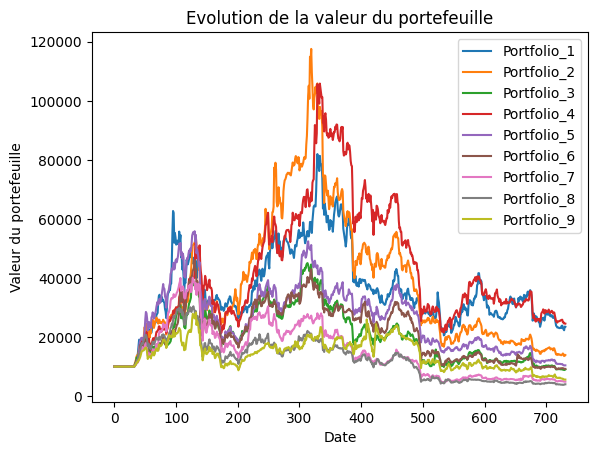

In [616]:


# Initialiser la valeur initiale du portefeuille
initial_portfolio_value = 10000  # Par exemple, 10000 USD

# Indices de portefeuille à considérer
portfolio_indices = range(1, 10)


# Calculer les valeurs des portefeuilles pour les dates de rééquilibrage
portfolio_values_dict = {}


for portfolio_index in portfolio_indices:
    portfolio_values = compute_portfolio_values(crypto_prices,portfolios_df, rebalancing_dates, portfolio_index, horizon=15, initial_value=initial_portfolio_value)
    portfolio_values_dict[f"Portfolio_{portfolio_index}"] = portfolio_values
portfolio_values_df = pd.DataFrame(portfolio_values_dict)

# Afficher les graphiques pour chaque indice de portefeuille
for portfolio_index, portfolio_values in portfolio_values_dict.items():
    plt.plot(portfolio_values, label=portfolio_index)

plt.title('Evolution de la valeur du portefeuille')
plt.xlabel('Date')
plt.ylabel('Valeur du portefeuille')
plt.legend()
plt.show()


On affiche finalement la valeur des portefeuilles de 1 à 9 au cours du temps. On s'attend à ce que les valeurs des portefeuille de faibles indices (1-3) soient en moyenne plus importantes que celles des portfeuilles de grands indices (7-9).

En effet le principe dde la stratégie Momentum s'appuie sur le fait que les actifs les plus performants devraient le rester dans un futur proche.

On ne pense en revanche pas forcément avoir des portefeuilles strictements ordonnées par leurs indices étant donné la forte volatilité des cryptos.

Sur la courbe de l'évolution des valeurs, on remarque dans un premier temps des tendances de marché, lors de la première moitié de la période étudié le marché composé de nos différentes crypto semble etre en tendance hausssière, puis lors de la seconde partie de la période étudiée celle-ci semble passer à la baisse.

Pour ce qui est de l'ordonnancement des valeurs des portefeuilles, on remarque par exemple que le portefeuille 4 qui devrait être etre le quatrième le plus performant si la stratégie du momentum de était parfaite, est enfaite celui qui donne en moyenne la meilleur rentabilité. Il est ensuite suivi par les portefuilles 1 et 2. 

Ces trois portefeuille se détachent des 6 autres portefeuilles en terme de valeur moyenne meme si le portefeuille 2 rejoint les 6 autres à la fin de la période d'étude en terme de valeur. Le portefeuille 9 qui devrait etre le moins performant fini avec une valeur supérieur à celle des portefeuilles 7 et 8 qui ferment la marche des rentabilité sur la période.

### Daily returns

In [617]:
def winsorize_series(series):
    # Calculer les quantiles à 5% et 95%
    q_05 = series.quantile(0.05)
    q_95 = series.quantile(0.95)
    
    # Remplacer les valeurs extrêmes par les quantiles à 5% et 95%
    series = series.clip(lower=q_05, upper=q_95)
    
    return series

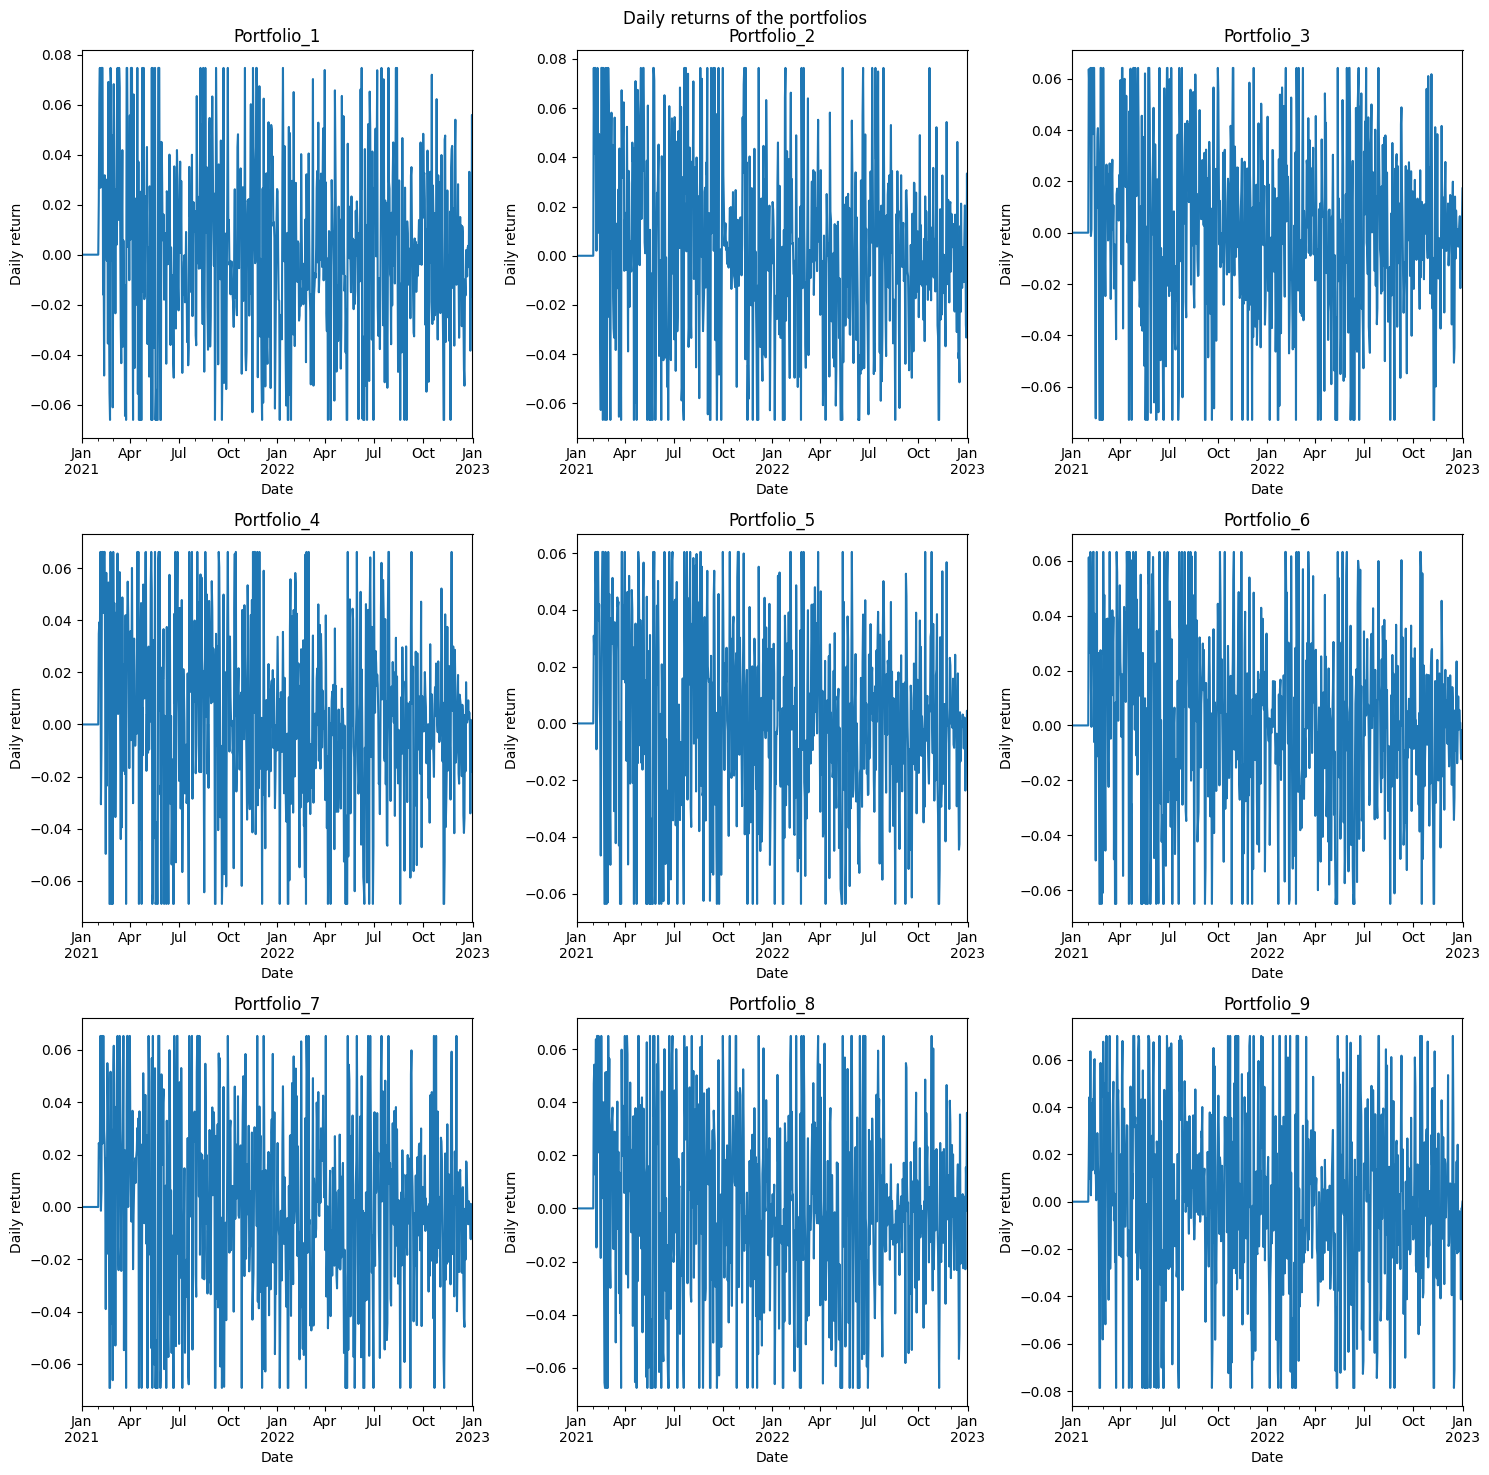

In [618]:
# Supprimer les valeurs NaN
portfolio_values_df = portfolio_values_df.dropna()

# Supprimer la première ligne
portfolio_values_df = portfolio_values_df.iloc[1:]

# Utiliser les timestamp de crypto_prices comme index
portfolio_values_df.index = crypto_prices.index

# Calculer les rendements quotidiens
portfolio_daily_returns = portfolio_values_df.pct_change()



# Appliquer la winsorisation sur chaque colonne du DataFrame
portfolio_daily_returns = portfolio_daily_returns.apply(winsorize_series, axis=0)

# Diviser le DataFrame en sous-groupes de 3 colonnes
num_subplots = len(portfolio_daily_returns.columns) // 3 + (len(portfolio_daily_returns.columns) % 3 > 0)

fig, axes = plt.subplots(num_subplots, 3, figsize=(15, 5 * num_subplots))
fig.suptitle('Daily returns of the portfolios')

# Afficher les sous-tracés
for i, ax in enumerate(axes.flat):
    if i < len(portfolio_daily_returns.columns):
        col_name = portfolio_daily_returns.columns[i]
        portfolio_daily_returns[col_name].plot(ax=ax, title=col_name, xlabel='Date', ylabel='Daily return')
    else:
        ax.axis('off')  # Masquer les sous-tracés excédentaires s'il y en a

plt.tight_layout()
plt.show()


On va ensuite étudier les rendements journaliers des différents portefeuilles. 

Le graphique qui affiche celle-ci au cours de la période d'étude des portfeuilles ne donne pas d'information claire sur des différences de performance entre les portefeuilles. 

Chacun d'eux connait des piques et des chutes importantes. Pour obtenir d'avantage d'information sur les daily returns on va alors faire une étude statistique de ceux-ci

In [619]:
first_date = data_factors['timestamp'].min()
last_date = crypto_prices.index.max()

all_dates = pd.date_range(start=first_date, end=last_date, freq='D')
rf_df = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'RF']], on='timestamp', how='left')
rf_df['RF'].fillna(method='ffill', inplace=True)
rf_df['RF'] = rf_df['RF'].str.replace(',', '.').astype(float)/100 

merged_df = portfolio_daily_returns.merge(rf_df, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_df = merged_df.loc[rebalancing_dates[0]:]
merged_df = merged_df.iloc[1:]
variance_merged = merged_df.std()


### Statistiques sur les daily returns


On affiche alors pour les daily returns de chacun des portefeuilles, leur moyenne, leur écart-type leur médianne le max et min ainsi que leur skewness et kurtosis

In [620]:
# Compute the indicators for each returns series
indicators = {}

for column in merged_df.columns:
    returns = merged_df[column]
    result = returns.describe()
    skewness = sm.stats.stattools.robust_skewness(returns)
    kurtosis = sm.stats.stattools.robust_kurtosis(returns)
    
    indicators[column] = {
        'Mean': result['mean'],
        'Stddev': result['std'],
        'Median': result['50%'],
        'Min': result['min'],
        'Max': result['max'],
        'Skewness': skewness[0],
        'Kurtosis': kurtosis[0]
    }

# Print the indicators for each returns series
for column, values in indicators.items():
    print(f"Indicators for {column}:")
    for indicator, value in values.items():
        print(f"{indicator}: {value}")
    print()

Indicators for Portfolio_1:
Mean: 0.0020619375530550113
Stddev: 0.036408751777410375
Median: 0.00044979488285279423
Min: -0.06608507442435893
Max: 0.0746825568195106
Skewness: 0.1275522065232528
Kurtosis: -0.461900975387846

Indicators for Portfolio_2:
Mean: 0.002141761146832258
Stddev: 0.03699395941549394
Median: 0.002020784381006502
Min: -0.06671835009826688
Max: 0.07634000762270918
Skewness: 0.09209099295943196
Kurtosis: -0.4645624894813527

Indicators for Portfolio_3:
Mean: 0.0010340651640736904
Stddev: 0.03517779639101694
Median: 0.0013356182989860965
Min: -0.07293436255602129
Max: 0.0641851694589669
Skewness: -0.20339706474078623
Kurtosis: -0.3953249603280451

Indicators for Portfolio_4:
Mean: 0.00238768149694065
Stddev: 0.03469816464480499
Median: 0.0027760074353029296
Min: -0.06887169290439071
Max: 0.06621000237835227
Skewness: -0.13211830967423652
Kurtosis: -0.4102855169592612

Indicators for Portfolio_5:
Mean: 0.0013528499820351014
Stddev: 0.03301318927898812
Median: 0.002613

**Expectations**:

On s'attend à obtenir des meilleurs moyennes pour les portefeuilles de faible indices notamment le 1 et le 4 qu'on a identifié comme étant ceux ayant les valeurs les plus élevées au cours de la période d'étude. 

On s'attend également à avoir poour chacun des portfeuille des valeurs d'ecart-type élevées étant données la volatilité du marché des cryptos et donc des max et min éloignés.

**Results**:

On observe bien que les portefeuilles 1 et 4 ont les rendements moyens les plus élevées qui sont tous les 2 supérieurs à 0.22 %.


In [621]:
columns_to_subtract = ['Portfolio_1', 'Portfolio_2', 'Portfolio_3', 'Portfolio_4', 'Portfolio_5', 'Portfolio_6', 'Portfolio_7', 'Portfolio_8', 'Portfolio_9']

for column in columns_to_subtract:
    merged_df[column] = merged_df[column] - merged_df['RF']


### Ratio de Sharpe

In [622]:
#on calcul le ration de sharpe pour chaque portfolio de 1 a 9
sharpe_ratios_portfolios = (merged_df.mean()) / variance_merged
print("Le ratio de sharpe des portefeuilles 1 à 9 :","\n",sharpe_ratios_portfolios[0:9])

Le ratio de sharpe des portefeuilles 1 à 9 : 
 Portfolio_1    0.055823
Portfolio_2    0.057097
Portfolio_3    0.028557
Portfolio_4    0.067963
Portfolio_5    0.040086
Portfolio_6    0.038035
Portfolio_7    0.014841
Portfolio_8    0.007721
Portfolio_9    0.012384
dtype: float64


### Calcul des ratio des Treynor / alpha de Jensen.

In [623]:

mkt_RF_df = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF']], on='timestamp', how='left')
mkt_RF_df['Mkt-RF'].fillna(method='ffill', inplace=True)
mkt_RF_df['Mkt-RF'] = mkt_RF_df['Mkt-RF'].str.replace(',', '.').astype(float)/100

merged_mkt_RF_df = merged_df.merge(mkt_RF_df, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_mkt_RF_df = merged_mkt_RF_df.loc[rebalancing_dates[0]:]
merged_mkt_RF_df = merged_mkt_RF_df.iloc[1:]

merged_mkt_RF_df.head()

,Portfolio_1,Portfolio_2,Portfolio_3,Portfolio_4,Portfolio_5,Portfolio_6,Portfolio_7,Portfolio_8,Portfolio_9,RF,Mkt-RF
timestamp,,,,,,,,,,,
2021-02-03,0.060593,0.041370,0.056166,0.039222,0.024428,0.026546,0.023094,0.054111,0.044119,0.0,0.0015
2021-02-04,0.074683,0.076340,0.041686,0.030821,0.025813,0.033574,0.018965,0.012805,0.009756,0.0,0.0123
2021-02-05,0.026753,0.076340,0.064185,0.066210,0.060451,0.063209,0.065363,0.036248,0.063519,0.0,0.0058
2021-02-06,0.068679,0.027178,-0.001297,-0.030620,0.048970,0.013618,-0.001443,0.063680,0.002718,0.0,0.0058
2021-02-07,0.074683,0.002044,0.001293,-0.009741,-0.009109,-0.000523,0.006110,-0.014703,0.021444,0.0,0.0058


### Regression pour obtenir les betas et alphas de Jensen

In [624]:

# Perform the regression for each portfolio
for portfolio_index in range(1, 10):
    # Select the portfolio values and the Mkt-RF column
    X = merged_mkt_RF_df['Mkt-RF']
    y = merged_mkt_RF_df[f'Portfolio_{portfolio_index}']
    
    # Add a constant term to the independent variable
    X = sm.add_constant(X)
    
    # Fit the linear regression model
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Get the intercept (alpha) and slope (beta) coefficients
    alpha = results.params[0]
    beta = results.params[1]
    
    # Calculate the p-value for the alpha coefficient at 10% significance level
    alpha_pvalue = results.pvalues[0]
    beta_pvalue = results.pvalues[1]   

    

    # Check if the p-value is less than or equal to 0.10
    print(f'Portfolio_{portfolio_index}:')
    print(f'Alpha (Jensen): {alpha} p-value: {alpha_pvalue}')
    print(f'Beta (Market): {beta} p-value: {beta_pvalue}')
    print()

Portfolio_1:
Alpha (Jensen): 0.0018901396852758344 p-value: 0.15608916185709498
Beta (Market): 0.7331396924262158 p-value: 1.4912021084518267e-12

Portfolio_2:
Alpha (Jensen): 0.001889702521103184 p-value: 0.16178009947712294
Beta (Market): 0.741486967852064 p-value: 1.655211726113785e-12

Portfolio_3:
Alpha (Jensen): 0.0008158465289421952 p-value: 0.5283281536458533
Beta (Market): 0.6311975470508904 p-value: 3.0876848805143995e-10

Portfolio_4:
Alpha (Jensen): 0.0022154317307663688 p-value: 0.08364312825895531
Beta (Market): 0.6144011135279346 p-value: 5.703554011742444e-10

Portfolio_5:
Alpha (Jensen): 0.001184975079672677 p-value: 0.32913005390319283
Beta (Market): 0.6123155081763707 p-value: 7.970026102671679e-11

Portfolio_6:
Alpha (Jensen): 0.0010805472317853275 p-value: 0.37627101525366313
Beta (Market): 0.69037700246685 p-value: 3.868869523515935e-13

Portfolio_7:
Alpha (Jensen): 0.00037272821493414515 p-value: 0.7709188509002843
Beta (Market): 0.7245797353798146 p-value: 3.664

### Ratio de Treynor

In [625]:

#on calcul le ration de sharpe pour chaque portfolio de 1 a 9
treynor_ratios_portfolios = (merged_df.mean()) / beta
print("Le ratio de treynor des portefeuilles 1 à 9 sont :","\n",treynor_ratios_portfolios[0:9])

Le ratio de treynor des portefeuilles 1 à 9 sont : 
 Portfolio_1    0.002217
Portfolio_2    0.002304
Portfolio_3    0.001096
Portfolio_4    0.002572
Portfolio_5    0.001444
Portfolio_6    0.001390
Portfolio_7    0.000568
Portfolio_8    0.000296
Portfolio_9    0.000528
dtype: float64


### Simulation de FAMA & FRENCH

In [626]:
fm_portfolios = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF','HML','SMB']], on='timestamp', how='left')
fm_portfolios['Mkt-RF'].fillna(method='ffill', inplace=True)
fm_portfolios['Mkt-RF'] = fm_portfolios['Mkt-RF'].str.replace(',', '.').astype(float)/100
fm_portfolios['HML'].fillna(method='ffill', inplace=True)
fm_portfolios['HML'] = fm_portfolios['HML'].str.replace(',', '.').astype(float)/100
fm_portfolios['SMB'].fillna(method='ffill', inplace=True)
fm_portfolios['SMB'] = fm_portfolios['SMB'].str.replace(',', '.').astype(float)/100

fm_portfolios = merged_df.merge(fm_portfolios, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
fm_portfolios = fm_portfolios.loc[rebalancing_dates[0]:]
fm_portfolios.head()


,Portfolio_1,Portfolio_2,Portfolio_3,Portfolio_4,Portfolio_5,Portfolio_6,Portfolio_7,Portfolio_8,Portfolio_9,RF,Mkt-RF,HML,SMB
timestamp,,,,,,,,,,,,,
2021-02-02,0.021151,0.076340,0.063678,0.034783,0.030922,0.061237,0.024386,0.047010,0.018269,0.0,0.0148,-0.0108,-0.0085
2021-02-03,0.060593,0.041370,0.056166,0.039222,0.024428,0.026546,0.023094,0.054111,0.044119,0.0,0.0015,0.0070,0.0043
2021-02-04,0.074683,0.076340,0.041686,0.030821,0.025813,0.033574,0.018965,0.012805,0.009756,0.0,0.0123,0.0037,0.0038
2021-02-05,0.026753,0.076340,0.064185,0.066210,0.060451,0.063209,0.065363,0.036248,0.063519,0.0,0.0058,-0.0047,0.0107
2021-02-06,0.068679,0.027178,-0.001297,-0.030620,0.048970,0.013618,-0.001443,0.063680,0.002718,0.0,0.0058,-0.0047,0.0107


In [627]:
# Select the independent variables (Mkt-RF, SMB, HML)
X = fm_portfolios[['Mkt-RF', 'SMB', 'HML']]

# Select the dependent variables (portfolio returns)
y = fm_portfolios[['Portfolio_1', 'Portfolio_2', 'Portfolio_3', 'Portfolio_4', 'Portfolio_5', 'Portfolio_6', 'Portfolio_7', 'Portfolio_8', 'Portfolio_9']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Select each portfolio as a dependent variable and perform OLS regression
coefficients = {}
alphas = {}
alpha_pvalues = {}

for portfolio in y.columns:
    # Select the current portfolio as the dependent variable
    current_y = y[portfolio]

    # Perform OLS regression
    model = sm.OLS(current_y, X)
    results = model.fit()

    # Get the coefficients
    Bmarket = results.params['Mkt-RF']
    Bsmb = results.params['SMB']
    Bhml = results.params['HML']

    # Get the p-values for the coefficients
    beta_pvalues = results.pvalues[1:]

    # Get the alpha (intercept)
    alpha = results.params['const']
    
    # Get the p-value for the alpha coefficient
    alpha_pvalue = results.pvalues[0]

    # Store coefficients and alpha in dictionaries
    coefficients[portfolio] = {'Bmarket': Bmarket, 'Bsmb': Bsmb, 'Bhml': Bhml}
    alphas[portfolio] = alpha
    alpha_pvalues[portfolio] = alpha_pvalue

    # Print the coefficients and p-values for each portfolio
    print(f"\nPortfolio: {portfolio}")
    print(f"Bmarket={Bmarket} (p-value={beta_pvalues[0]}), Bsmb={Bsmb} (p-value={beta_pvalues[1]}), Bhml={Bhml} (p-value={beta_pvalues[2]})")
    print(f"Alpha={alpha} (p-value={alpha_pvalue})")



Portfolio: Portfolio_1
Bmarket=0.7336355093033542 (p-value=1.866858752193314e-10), Bsmb=0.1570065586509395 (p-value=0.42739481539764257), Bhml=0.07707468903871502 (p-value=0.5587001559523255)
Alpha=0.0018489467795817852 (p-value=0.1680094314165914)

Portfolio: Portfolio_2
Bmarket=0.7823027725871392 (p-value=2.3963178495437243e-11), Bsmb=0.05903097832914721 (p-value=0.7688862701853802), Bhml=0.1247826246804167 (p-value=0.3513914745806962)
Alpha=0.0018421133855495715 (p-value=0.17628325723763696)

Portfolio: Portfolio_3
Bmarket=0.6516290871774878 (p-value=5.641652646379592e-09), Bsmb=-0.03689634474986075 (p-value=0.8480533572629947), Bhml=0.021548640965785435 (p-value=0.866630197441898)
Alpha=0.0008552484478687808 (p-value=0.5122597777226547)

Portfolio: Portfolio_4
Bmarket=0.6721719218965713 (p-value=1.1618939011139178e-09), Bsmb=-0.11396761314726846 (p-value=0.5486487708792714), Bhml=0.10107517740340301 (p-value=0.42473335126841416)
Alpha=0.0020951164105646367 (p-value=0.1039882270128

In [628]:

# Création d'un DataFrame vide pour les cryptomonnaies centralisées
centralized_df = pd.DataFrame()

# Liste des noms de cryptomonnaies centralisées
centralized_crypto_names = exchange_info[exchange_info['CeX'] == True]['Unnamed: 0'].values

# Parcourir les colonnes du DataFrame crypto_prices
for crypto in crypto_prices.columns:
    # Vérifier si la cryptomonnaie est centralisée
    if crypto in centralized_crypto_names:
        # Ajouter la cryptomonnaie au DataFrame centralized_df
        centralized_df[crypto] = crypto_prices[crypto]

# on fait pareil pour les cryptomonnaies décentralisées
decentralized_df = pd.DataFrame()
decentralized_crypto_names = exchange_info[exchange_info['DeX'] == True]['Unnamed: 0'].values
for crypto in crypto_prices.columns:
    if crypto in decentralized_crypto_names:
        decentralized_df[crypto] = crypto_prices[crypto]
centralized_df.head()
    

,unfi-busd,iota-usd,bhp-usdt,dot-usdt,aave-usdt,nmc-usdt,mx-usdt,dht-usdt,crv-usd,pha-usdt,...,gala-usdt,api3-usdt,1inch-usdt,comp-usdt,ersdl-usdt,xor-usdt,ren-usdt,mkr-usdt,prq-usdt,mta-usdt
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01,5.562509,0.294552,0.664400,8.798804,87.590000,0.439790,0.1436,0.859310,0.637000,0.118509,...,0.001185,1.801849,1.167545,144.668659,0.008365,102.525652,0.327979,589.914791,0.527962,0.909049
2021-01-02,5.221067,0.286993,0.667342,8.760201,85.937751,0.459137,0.1452,0.992900,0.592534,0.117040,...,0.001151,1.834821,1.090871,140.000168,0.008287,98.931513,0.312595,597.494350,0.460791,1.011624
2021-01-03,6.482086,0.298317,0.667600,9.279673,87.968375,0.507415,0.1388,0.959000,0.621000,0.115557,...,0.001182,1.889542,1.084320,145.591570,0.009397,101.388139,0.325757,672.198175,0.507648,1.160168
2021-01-04,5.851341,0.317800,0.660000,9.465044,102.336182,0.521261,0.1384,1.057248,0.672000,0.114000,...,0.001310,2.175675,1.076138,145.562839,0.012118,110.576618,0.329471,678.422680,0.451232,1.165947
2021-01-05,5.751700,0.354807,0.652600,9.612824,114.077356,0.510710,0.1376,1.171523,0.680000,0.115772,...,0.001525,2.388763,1.141967,155.225308,0.012469,115.365119,0.335810,705.739433,0.608839,1.199186


### Etude du portefeuille long sur 1 et short sur 9

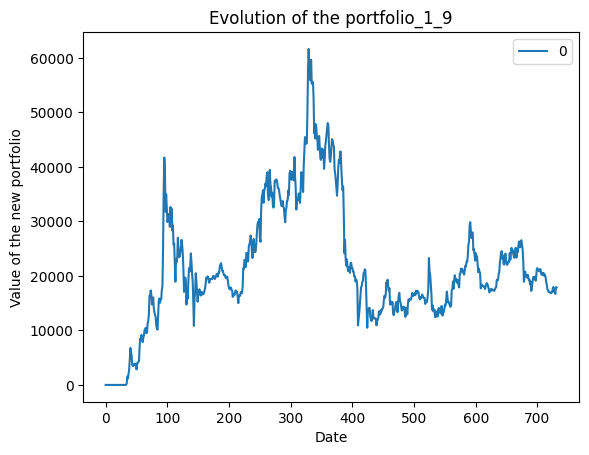

In [629]:
# Get the values of Portfolio 1 and the last portfolio
portfolio_1_values = portfolio_values_dict["Portfolio_1"]
last_portfolio_values = portfolio_values_dict[f"Portfolio_{len(portfolio_values_dict)}"]

# Create a new portfolio that buys Portfolio 1 and sells the last portfolio
portfolio_1_9 = pd.Series(portfolio_1_values) - pd.Series(last_portfolio_values)
#on convertit portfolio_1_9 en dataframe
portfolio_1_9 = pd.DataFrame(portfolio_1_9)
# Plot the values of all portfolios
portfolio_values_df = pd.DataFrame(portfolio_values_dict)
# Plot the new portfolio values P1_9
portfolio_1_9.plot(title='Evolution of the portfolio_1_9', xlabel='Date', ylabel='Value of the new portfolio')
plt.show()


### Daily returns

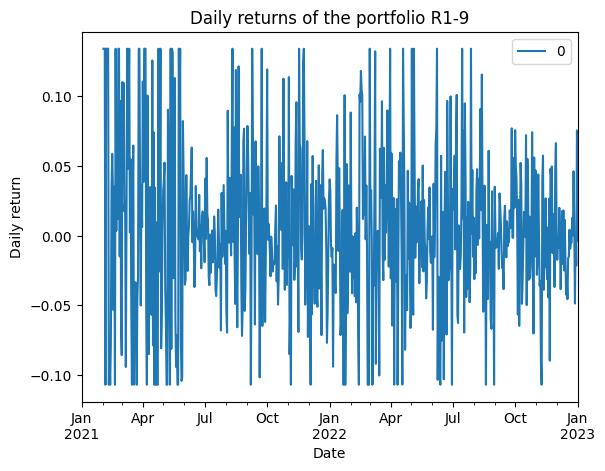

In [630]:
portfolio_1_9 = portfolio_1_9.iloc[1:]
portfolio_1_9.index = crypto_prices.index
portfolio_1_9_daily_returns = portfolio_1_9.pct_change()
# Apply winsorization to the daily returns of the new portfolio
portfolio_1_9_daily_returns = portfolio_1_9_daily_returns.apply(winsorize_series, axis=0)
portfolio_1_9_daily_returns.plot(title='Daily returns of the portfolio R1-9', xlabel='Date', ylabel='Daily return')
plt.show()

On fait R-Rf pour faciliter les calculs suivants

In [631]:
rf_df_1_9 = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'RF']], on='timestamp', how='left')
rf_df_1_9['RF'].fillna(method='ffill', inplace=True)
rf_df_1_9['RF'] = rf_df_1_9['RF'].str.replace(',', '.').astype(float)/100

merged_df_1_9 = portfolio_1_9_daily_returns.merge(rf_df_1_9, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_df_1_9 = merged_df_1_9.loc[rebalancing_dates[0]:]
merged_df_1_9 = merged_df_1_9.iloc[2:]
variance_merged_1_9 = merged_df_1_9.std()
merged_df_1_9[0] = merged_df_1_9[0] - merged_df_1_9['RF']
merged_df_1_9.head()

,0,RF
timestamp,,
2021-02-03,0.134240,0.0
2021-02-04,0.134240,0.0
2021-02-05,-0.107026,0.0
2021-02-06,0.134240,0.0
2021-02-07,0.134240,0.0


### Simulation de FAMA & FRENCH

### Ratio de sharpe Portefeuille P1-9

In [632]:
sharpe_ratio_p1_9 = merged_df_1_9.mean() / variance_merged_1_9
print("Le ratio de sharpe du portefeuille P1-9 est :", sharpe_ratio_p1_9[0])

Le ratio de sharpe du portefeuille P1-9 est : 0.07280315268538481


In [633]:
mkt_RF_df_1_9 = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF']], on='timestamp', how='left')
mkt_RF_df_1_9['Mkt-RF'].fillna(method='ffill', inplace=True)
mkt_RF_df_1_9['Mkt-RF'] = mkt_RF_df_1_9['Mkt-RF'].str.replace(',', '.').astype(float)/100

merged_mkt_RF_df_1_9 = portfolio_1_9_daily_returns.merge(mkt_RF_df_1_9, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_mkt_RF_df_1_9 = merged_mkt_RF_df_1_9.loc[rebalancing_dates[0]:]
merged_mkt_RF_df_1_9 = merged_mkt_RF_df_1_9.iloc[2:]

### Simulation Alpha de Jensen

In [634]:
# Select the portfolio values and the Mkt-RF column
X = merged_mkt_RF_df_1_9['Mkt-RF']
y = merged_mkt_RF_df_1_9[0]

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Get the intercept (alpha) and slope (beta) coefficients
alpha_1_9 = results.params[0]
beta_1_9 = results.params[1]
alpha_pvalue_1_9 = results.pvalues[0]

# Print the alpha and beta coefficients
print(f'Portfolio_1_9:')
print(f'Alpha (Jensen): {alpha_1_9} p-value: {alpha_pvalue_1_9}')
print(f'Beta (Market): {beta_1_9}')
print()

Portfolio_1_9:
Alpha (Jensen): 0.004182545435992004 p-value: 0.05661646758065175
Beta (Market): 0.673557484355144



### Ratio de Treynor

In [635]:
#on calcul le ration de sharpe pour le portefeuille P1-9
treynor_ratios_1_9_portfolio = (merged_mkt_RF_df_1_9.mean() ) / beta_1_9
print("Le ratio de treynor des portefeuilles 1 à 9 sont :","\n",treynor_ratios_1_9_portfolio[0])

Le ratio de treynor des portefeuilles 1 à 9 sont : 
 0.006366367494938115


### Simulation FAMA FRENCH

In [636]:
fm_portfolio_1_9 = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF','HML','SMB']], on='timestamp', how='left')
fm_portfolio_1_9['Mkt-RF'].fillna(method='ffill', inplace=True)
fm_portfolio_1_9['Mkt-RF'] = fm_portfolio_1_9['Mkt-RF'].str.replace(',', '.').astype(float)/100
fm_portfolio_1_9['HML'].fillna(method='ffill', inplace=True)
fm_portfolio_1_9['HML'] = fm_portfolio_1_9['HML'].str.replace(',', '.').astype(float)/100
fm_portfolio_1_9['SMB'].fillna(method='ffill', inplace=True)
fm_portfolio_1_9['SMB'] = fm_portfolio_1_9['SMB'].str.replace(',', '.').astype(float)/100

fm_portfolio_1_9 = merged_df_1_9.merge(fm_portfolio_1_9, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
fm_portfolio_1_9 = fm_portfolio_1_9.loc[rebalancing_dates[0]:]
X = fm_portfolio_1_9[['Mkt-RF', 'SMB', 'HML']]

fm_portfolio_1_9.head()


,0,RF,Mkt-RF,HML,SMB
timestamp,,,,,
2021-02-03,0.134240,0.0,0.0015,0.0070,0.0043
2021-02-04,0.134240,0.0,0.0123,0.0037,0.0038
2021-02-05,-0.107026,0.0,0.0058,-0.0047,0.0107
2021-02-06,0.134240,0.0,0.0058,-0.0047,0.0107
2021-02-07,0.134240,0.0,0.0058,-0.0047,0.0107


In [637]:

# Select the independent variables (Mkt-RF, SMB, HML)

# Select the dependent variables (portfolio returns)
y = fm_portfolio_1_9[0]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Select each portfolio as a dependent variable and perform OLS regression
coefficients = {}
alphas = {}
alpha_pvalues = {}


# Select the current portfolio as the dependent variable
current_y = y

# Perform OLS regression
model = sm.OLS(current_y, X)
results = model.fit()

# Get the coefficients
Bmarket = results.params['Mkt-RF']
Bsmb = results.params['SMB']
Bhml = results.params['HML']

# Get the alpha (intercept)
alpha = results.params['const']
#get the p-value for the alpha coefficient
alpha_pvalue = results.pvalues[0]

# Store coefficients and alpha in dictionaries
coefficients[portfolio] = {'Bmarket': Bmarket, 'Bsmb': Bsmb, 'Bhml': Bhml}
alphas[portfolio] = alpha
alpha_pvalues[portfolio] = alpha_pvalue

# Print the coefficients and alphas for each portfolio
print("Coefficients:")
for portfolio, coeffs in coefficients.items():
    print(f"{portfolio}: Bmarket={coeffs['Bmarket']} p-value={beta_pvalues[0]}, Bsmb={coeffs['Bsmb']} p-value={beta_pvalues[1]}, Bhml={coeffs['Bhml']} p-value={beta_pvalues[2]}")

print("\nAlphas:")
for portfolio, alpha in alphas.items():
    print(f"{portfolio}: Alpha={alpha} p-value={alpha_pvalues[portfolio]}")


Coefficients:
Portfolio_9: Bmarket=0.630977320709324 p-value=3.222853347834567e-14, Bsmb=0.5878318326668064 p-value=0.6582830423297729, Bhml=0.1739025214803687 p-value=0.9575903753869481

Alphas:
Portfolio_9: Alpha=0.0040838417699152925 p-value=0.06427958402877026


# Etude de R1 - R9

### Daily returns

<AxesSubplot:title={'center':'Daily returns of the portfolio R1-R9'}, xlabel='Date', ylabel='Daily return'>

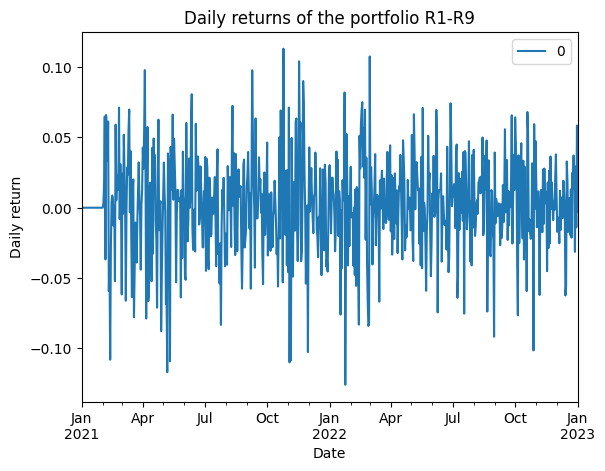

In [638]:
#on calcul et on affiche la difference de rentabilite entre le portefeuille 1 et le 9
portfolio_1_minus_9 = portfolio_daily_returns["Portfolio_1"] - portfolio_daily_returns["Portfolio_9"]
portfolio_1_minus_9 = pd.DataFrame(portfolio_1_minus_9)

portfolio_1_minus_9.index = crypto_prices.index
portfolio_1_minus_9.plot(title='Daily returns of the portfolio R1-R9', xlabel='Date', ylabel='Daily return')


In [639]:
first_date = data_factors['timestamp'].min()
last_date = crypto_prices.index.max()

all_dates = pd.date_range(start=first_date, end=last_date, freq='D')
rf_df = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'RF']], on='timestamp', how='left')
rf_df['RF'].fillna(method='ffill', inplace=True)
rf_df['RF'] = rf_df['RF'].str.replace(',', '.').astype(float)/100 

merged_1_minus_9_df = portfolio_1_minus_9.merge(rf_df, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_1_minus_9_df = merged_1_minus_9_df.loc[rebalancing_dates[0]:]
merged_1_minus_9_df = merged_1_minus_9_df.iloc[1:]
#on rename la colonne
merged_1_minus_9_df = merged_1_minus_9_df.rename(columns={merged_1_minus_9_df.columns[0]: 'R1-R9'})
merged_1_minus_9_df.head()

,R1-R9,RF
timestamp,,
2021-02-02,0.002883,0.0
2021-02-03,0.016474,0.0
2021-02-04,0.064926,0.0
2021-02-05,-0.036766,0.0
2021-02-06,0.065962,0.0


### Statistiques sur les daily returns

In [640]:
# Compute the indicators for each returns series
indicators = {}

for column in merged_1_minus_9_df:
    returns = merged_1_minus_9_df[column]
    result = returns.describe()
    skewness = sm.stats.stattools.robust_skewness(returns)
    kurtosis = sm.stats.stattools.robust_kurtosis(returns)
    
    indicators[column] = {
        'Mean': result['mean'],
        'Stddev': result['std'],
        'Median': result['50%'],
        'Min': result['min'],
        'Max': result['max'],
        'Skewness': skewness[0],
        'Kurtosis': kurtosis[0]
    }

# Indicator for R1-R9
print("Indicators for R1-R9:")
for indicator, value in indicators['R1-R9'].items():
    print(f"{indicator}: {value}")
print()

Indicators for R1-R9:
Mean: 0.0015488259537005413
Stddev: 0.035387188064408874
Median: 0.004257558219115776
Min: -0.12597732844132958
Max: 0.11316602901042867
Skewness: -0.2727227582098705
Kurtosis: 0.7887204205663334



### Ratio de Sharpe

In [641]:
ratio_sharpe_portfolio_1_minus_9 = portfolio_1_minus_9.mean() / portfolio_1_minus_9.std()
print("Le ratio de Sharpe de portfolio_1_minus_9 est :", ratio_sharpe_portfolio_1_minus_9[0])


Le ratio de Sharpe de portfolio_1_minus_9 est : 0.042828142851334745


### Simulation Alpha de Jensen

In [642]:

mkt_RF_df_1_minus_9 = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF']], on='timestamp', how='left')
mkt_RF_df_1_minus_9['Mkt-RF'].fillna(method='ffill', inplace=True)
mkt_RF_df_1_minus_9['Mkt-RF'] = mkt_RF_df_1_minus_9['Mkt-RF'].str.replace(',', '.').astype(float)

merged_mkt_RF_df_1_minus_9 = portfolio_1_minus_9.merge(mkt_RF_df_1_minus_9, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_mkt_RF_df_1_minus_9 = merged_mkt_RF_df_1_minus_9.loc[rebalancing_dates[0]:]
merged_mkt_RF_df_1_minus_9 = merged_mkt_RF_df_1_minus_9.iloc[2:]

In [643]:
# Select the portfolio values and the Mkt-RF column
X = merged_mkt_RF_df_1_minus_9['Mkt-RF']
y = merged_mkt_RF_df_1_minus_9[0]

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Get the intercept (alpha) and slope (beta) coefficients
alpha_1_minus_9 = results.params[0]
alpha_pvalue_1_minus_9 = results.pvalues[0]
beta_1_minus_9 = results.params[1]
beta_pvalue_1_minus_9 = results.pvalues[1]

# Print the alpha and beta coefficients
print(f'Portfolio_1_minus_9:')
print(f'Alpha (Jensen): {alpha_1_minus_9} p-value: {alpha_pvalue_1_minus_9}')
print(f'Beta (Market): {beta_1_minus_9} p-value: {beta_pvalue_1_minus_9}')
print()


Portfolio_1_minus_9:
Alpha (Jensen): 0.0015756840494420775 p-value: 0.23946468483158798
Beta (Market): -0.0018355298657553253 p-value: 0.07312461274076591



### Ratio de Treynor

In [644]:
#on calcul le ration de sharpe pour le portefeuille R1-R9
treynor_ratios_1_minus_9_portfolio = (merged_mkt_RF_df_1_minus_9.mean() ) / beta_1_minus_9
print("Le ratio de treynor du portefeuille 1 moins le portefeuile 9 :","\n",treynor_ratios_1_minus_9_portfolio[0])

Le ratio de treynor du portefeuille 1 moins le portefeuile 9 : 
 -0.8427621755495618


### Simulation de Fama FRENCH

In [645]:
fm_portfolio_1_minus_9 = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF','HML','SMB']], on='timestamp', how='left')
fm_portfolio_1_minus_9['Mkt-RF'].fillna(method='ffill', inplace=True)
fm_portfolio_1_minus_9['Mkt-RF'] = fm_portfolio_1_minus_9['Mkt-RF'].str.replace(',', '.').astype(float)/100
fm_portfolio_1_minus_9['HML'].fillna(method='ffill', inplace=True)
fm_portfolio_1_minus_9['HML'] = fm_portfolio_1_minus_9['HML'].str.replace(',', '.').astype(float)/100
fm_portfolio_1_minus_9['SMB'].fillna(method='ffill', inplace=True)
fm_portfolio_1_minus_9['SMB'] = fm_portfolio_1_minus_9['SMB'].str.replace(',', '.').astype(float)/100

fm_portfolio_1_minus_9 = merged_1_minus_9_df.merge(fm_portfolio_1_minus_9, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
fm_portfolio_1_minus_9 = fm_portfolio_1_minus_9.loc[rebalancing_dates[0]:]
X = fm_portfolio_1_minus_9[['Mkt-RF', 'SMB', 'HML']]

fm_portfolio_1_minus_9.head()


,R1-R9,RF,Mkt-RF,HML,SMB
timestamp,,,,,
2021-02-02,0.002883,0.0,0.0148,-0.0108,-0.0085
2021-02-03,0.016474,0.0,0.0015,0.0070,0.0043
2021-02-04,0.064926,0.0,0.0123,0.0037,0.0038
2021-02-05,-0.036766,0.0,0.0058,-0.0047,0.0107
2021-02-06,0.065962,0.0,0.0058,-0.0047,0.0107


In [646]:

# Select the independent variables (Mkt-RF, SMB, HML)

# Select the dependent variables (portfolio returns)
y = fm_portfolio_1_minus_9['R1-R9']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Select each portfolio as a dependent variable and perform OLS regression
coefficients = {}
alphas = {}
alpha_pvalues = {}

# Select the current portfolio as the dependent variable
current_y = y

# Perform OLS regression
model = sm.OLS(current_y, X)
results = model.fit()

# Get the coefficients
Bmarket = results.params['Mkt-RF']
Bsmb = results.params['SMB']
Bhml = results.params['HML']

# Get the alpha (intercept)
alpha = results.params['const']
#get the p-value for the alpha coefficient
alpha_pvalue = results.pvalues[0]

# Store coefficients and alpha in dictionaries
coefficients[portfolio] = {'Bmarket': Bmarket, 'Bsmb': Bsmb, 'Bhml': Bhml}
alphas[portfolio] = alpha
alpha_pvalues[portfolio] = alpha_pvalue

# Print the coefficients and alphas for each portfolio
print("Coefficients:")
for portfolio, coeffs in coefficients.items():
    print(f"{portfolio}: Bmarket={coeffs['Bmarket']} p-value={beta_pvalues[0]}, Bsmb={coeffs['Bsmb']} p-value={beta_pvalues[1]}, Bhml={coeffs['Bhml']} p-value={beta_pvalues[2]}")

print("\nAlphas:")
for portfolio, alpha in alphas.items():
    print(f"{portfolio}: Alpha={alpha} p-value={alpha_pvalues[portfolio]}")


Coefficients:
Portfolio_9: Bmarket=-0.19711545251014212 p-value=3.222853347834567e-14, Bsmb=0.2496186251664234 p-value=0.6582830423297729, Bhml=0.0844937499943443 p-value=0.9575903753869481

Alphas:
Portfolio_9: Alpha=0.0015435144063593326 p-value=0.25189541546129834


# Etude des crypto centralisées

In [647]:
portfolio_1_8_centralized = get_portfolio_compo(centralized_df, rebalancing_dates, portfolio_index=8, horizon=15)
premier_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=1, horizon=15, initial_value=initial_portfolio_value)
deuxieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=2, horizon=15, initial_value=initial_portfolio_value)
troisieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=3, horizon=15, initial_value=initial_portfolio_value)
quatrieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=4, horizon=15, initial_value=initial_portfolio_value)
cinquieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=5, horizon=15, initial_value=initial_portfolio_value)
sixieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=6, horizon=15, initial_value=initial_portfolio_value)
septieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=7, horizon=15, initial_value=initial_portfolio_value)
huitieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=8, horizon=15, initial_value=initial_portfolio_value)


**Expectations**

D'après la première partie de nos études, nous nous attendons à observer, tout comme dans cette première partie, une tendance haussière au cours de la première période, suivie d'une tendance baissière pour la seconde partie. Le portefeuille 4 semble également avoir été le plus performant lors de la première partie. De manière générale, nous anticipons des résultats similaires à ceux de la première partie en raison du fait que la majorité des cryptomonnaies sont centralisées.

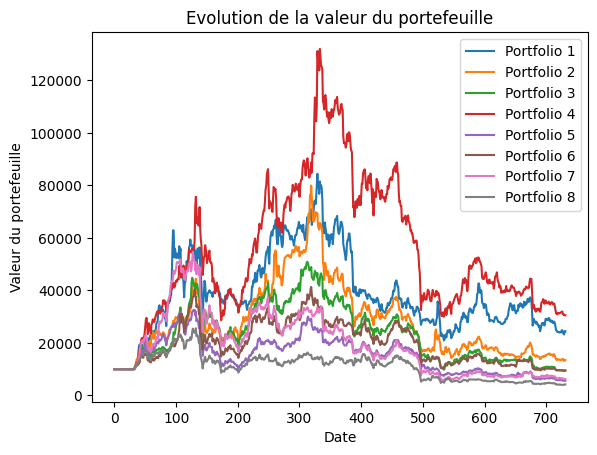

In [648]:
portfolios = [premier_portefeuille_centralise, deuxieme_portefeuille_centralise, troisieme_portefeuille_centralise, quatrieme_portefeuille_centralise, cinquieme_portefeuille_centralise, sixieme_portefeuille_centralise, septieme_portefeuille_centralise, huitieme_portefeuille_centralise]

for i, portfolio in enumerate(portfolios, start=1):
    plt.plot(portfolio, label=f"Portfolio {i}")

plt.title('Evolution de la valeur du portefeuille')
plt.xlabel('Date')
plt.ylabel('Valeur du portefeuille')
plt.legend()    
plt.show()

**Results**:

On obtient un graphique très similaire à la première partie comme prévu dû à une majorité de cryptomonnaie qui sont centralisées.


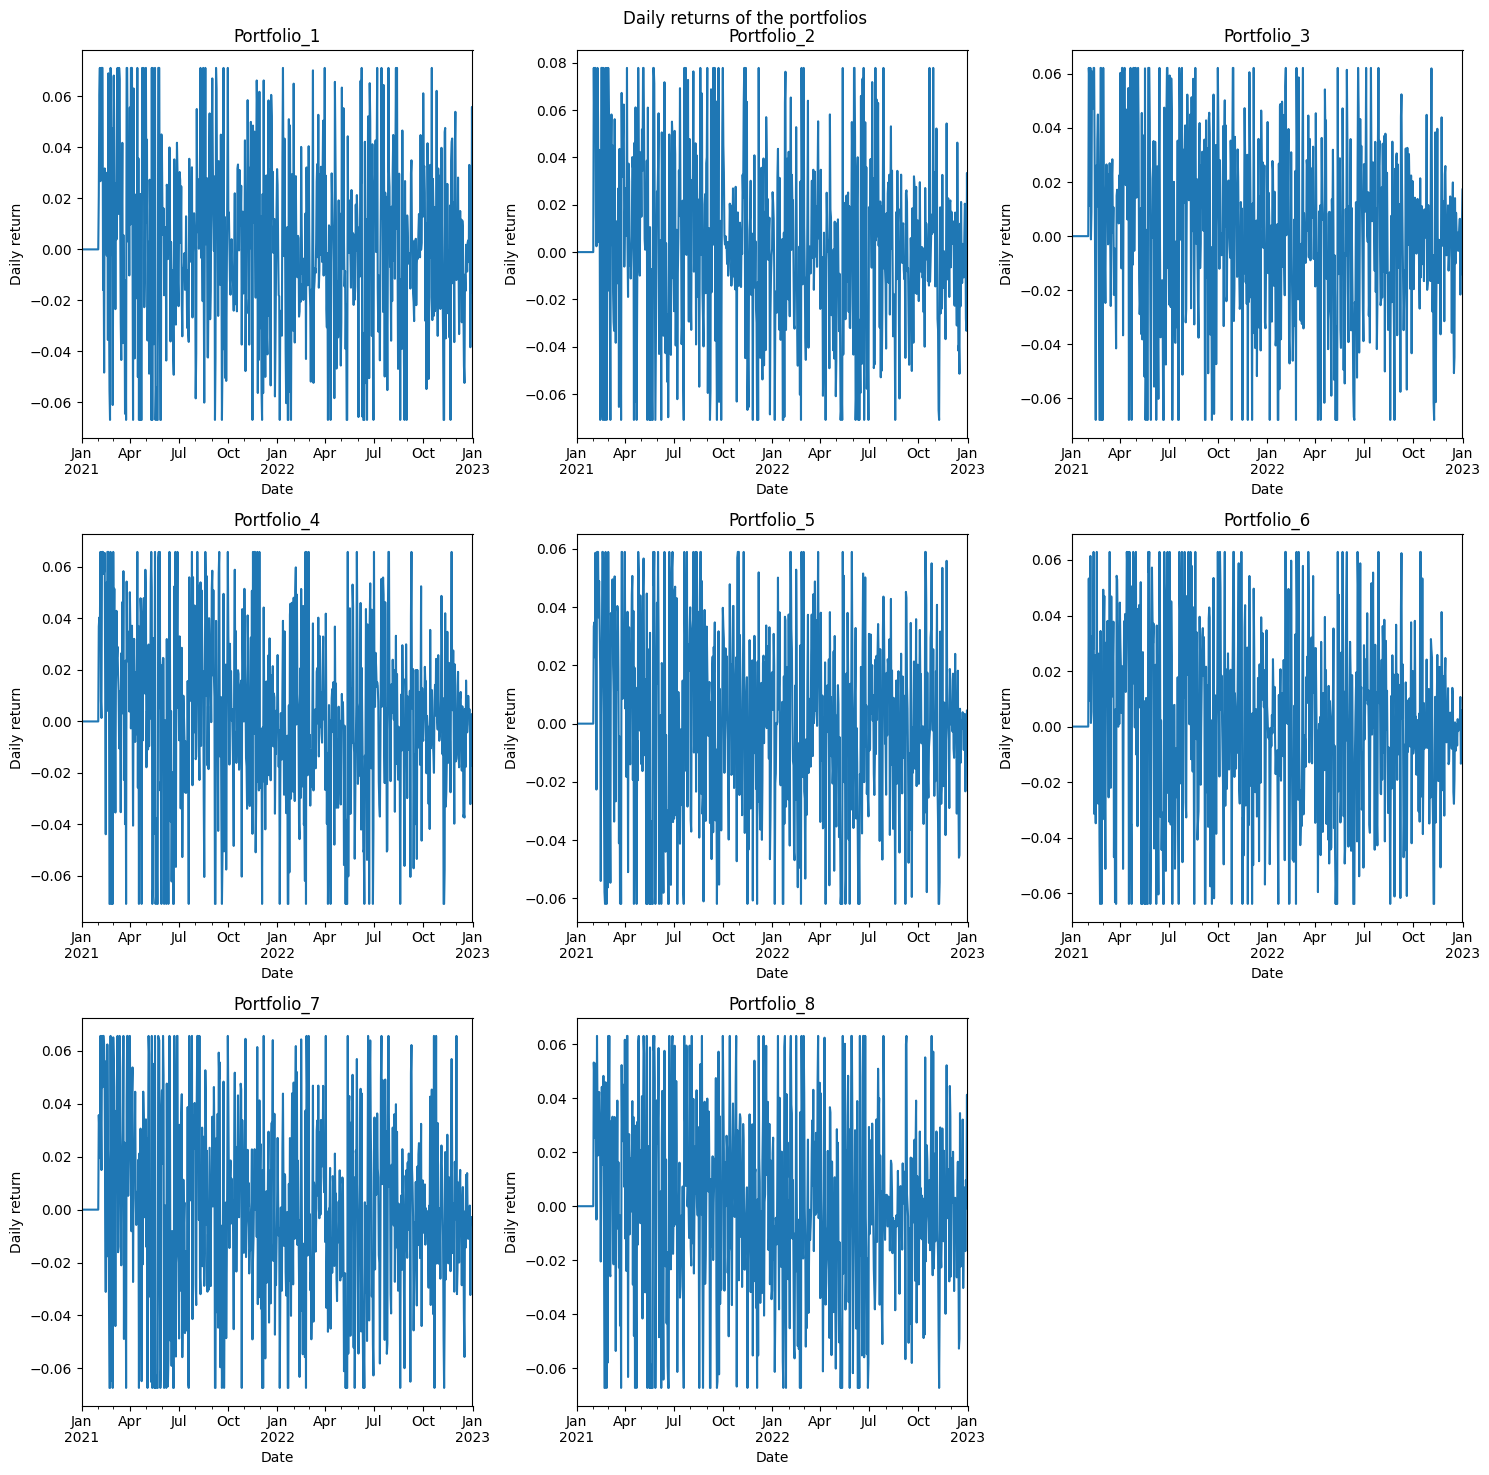

In [649]:


# Créer une liste de noms de portefeuilles
portfolio_names = ["Portfolio_1", "Portfolio_2", "Portfolio_3", "Portfolio_4", 
                   "Portfolio_5", "Portfolio_6", "Portfolio_7", "Portfolio_8"]

# Créer une liste des portefeuilles centralisés
centralized_portfolios = [premier_portefeuille_centralise, deuxieme_portefeuille_centralise,
                          troisieme_portefeuille_centralise, quatrieme_portefeuille_centralise,
                          cinquieme_portefeuille_centralise, sixieme_portefeuille_centralise,
                          septieme_portefeuille_centralise, huitieme_portefeuille_centralise]

# Créer un dictionnaire de données pour le DataFrame
portfolio_values_dict_centralized = {name: portfolio for name, portfolio in zip(portfolio_names, centralized_portfolios)}

# Créer le DataFrame
portfolio_values_df_centralized = pd.DataFrame(portfolio_values_dict_centralized)
portfolio_values_df_centralized = portfolio_values_df_centralized.dropna()
portfolio_values_df_centralized = portfolio_values_df_centralized.iloc[1:]
portfolio_values_df_centralized.index = centralized_df.index

# Calculer les rendements quotidiens
portfolio_daily_returns_centralized = portfolio_values_df_centralized.pct_change()
# Appliquer la winsorisation sur chaque colonne du DataFrame
portfolio_daily_returns_centralized = portfolio_daily_returns_centralized.apply(winsorize_series, axis=0)

# Déterminer le nombre de sous-tracés nécessaires
num_subplots = len(portfolio_daily_returns_centralized.columns) // 3 + (len(portfolio_daily_returns_centralized.columns) % 3 > 0)

# Créer les sous-tracés
fig, axes = plt.subplots(num_subplots, 3, figsize=(15, 5 * num_subplots))
fig.suptitle('Daily returns of the portfolios')

# Afficher les graphiques
for i, ax in enumerate(axes.flat):
    if i < len(portfolio_daily_returns_centralized.columns):
        col_name = portfolio_daily_returns_centralized.columns[i]
        portfolio_daily_returns_centralized[col_name].plot(ax=ax, title=col_name, xlabel='Date', ylabel='Daily return')
    else:
        ax.axis('off')  # Masquer les sous-tracés excédentaires s'il y en a

plt.tight_layout()
plt.show()


**Expectations**

On s'attend à obtenir de meilleures moyennes pour les portefeuilles de faible indice, notamment le 1 et le 4, que nous avons identifiés comme ayant les valeurs les plus élevées au cours de la période d'étude. De plus, nous anticipons des valeurs d'écart-type élevées pour chacun des portefeuilles, étant donné la volatilité du marché des cryptomonnaies, ce qui se traduira par des valeurs maximales et minimales éloignées.


In [650]:
first_date = data_factors['timestamp'].min()
last_date = portfolio_daily_returns_centralized.index.max()

all_dates = pd.date_range(start=first_date, end=last_date, freq='D')
rf_df = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'RF']], on='timestamp', how='left')
rf_df['RF'].fillna(method='ffill', inplace=True)
rf_df['RF'] = rf_df['RF'].str.replace(',', '.').astype(float)/100 

merged_centralized = portfolio_daily_returns_centralized.merge(rf_df, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_centralized = merged_centralized.loc[rebalancing_dates[0]:]
merged_centralized = merged_centralized.iloc[1:]
variance_merged_centralized = merged_centralized.std()

### Analyse statistique

In [651]:
#on fait les stats sur les daily return
indicators_centralized = {}

for column in merged_centralized.columns:
    returns = merged_centralized[column]
    result = returns.describe()
    skewness = sm.stats.stattools.robust_skewness(returns)
    kurtosis = sm.stats.stattools.robust_kurtosis(returns)
    
    indicators_centralized[column] = {
        'Mean': result['mean'],
        'Stddev': result['std'],
        'Median': result['50%'],
        'Min': result['min'],
        'Max': result['max'],
        'Skewness': skewness[0],
        'Kurtosis': kurtosis[0]
    }


# Print the indicators for each returns series
for column, values in indicators_centralized.items():
    print(f"Indicators for {column}:")
    for indicator, value in values.items():
        print(f"{indicator}: {value}")
    print()



Indicators for Portfolio_1:
Mean: 0.0018620020741610668
Stddev: 0.035826011784904736
Median: 0.0010642270125025277
Min: -0.06690367220665486
Max: 0.0711879655776918
Skewness: 0.05286129510924945
Kurtosis: -0.4658153922269306

Indicators for Portfolio_2:
Mean: 0.0018977885885459267
Stddev: 0.03803486727756151
Median: 0.0018247325972522432
Min: -0.07092003522260908
Max: 0.07782226819711971
Skewness: 0.0575562557191799
Kurtosis: -0.38769624616823073

Indicators for Portfolio_3:
Mean: 0.0016049846984032775
Stddev: 0.0335769339360657
Median: 0.0020872533784028757
Min: -0.06795529846156101
Max: 0.062211174874744334
Skewness: -0.1731690721057565
Kurtosis: -0.4700125223437701

Indicators for Portfolio_4:
Mean: 0.00219233507556838
Stddev: 0.03452177698502755
Median: 0.003082029828009647
Min: -0.07088482497259341
Max: 0.06584428645225117
Skewness: -0.16572183622660028
Kurtosis: -0.341750616004711

Indicators for Portfolio_5:
Mean: 0.0008033790784479958
Stddev: 0.03213432079552355
Median: 0.00152

**Results**

On observe effectivement que les portefeuilles 1 et 4 affichent des rendements moyens élevés, tous les deux supérieurs à 0,18 %. Cependant, cette fois-ci, le portefeuille 2 présente également l'un des rendements les plus élevés, à 0,18 %.

En ce qui concerne les portefeuilles les moins performants, ils correspondent bien aux portefeuilles 7 et 8, qui affichent des rentabilités moyennes proches de 0 (10^-4).

Comme précédemment, on constate que l'écart-type pour l'ensemble des portefeuilles est proche de 4 %, en raison de la grande volatilité du marché des cryptomonnaies.

In [652]:
columns_to_subtract = ['Portfolio_1', 'Portfolio_2', 'Portfolio_3', 'Portfolio_4', 'Portfolio_5', 'Portfolio_6', 'Portfolio_7', 'Portfolio_8']

for column in columns_to_subtract:
    merged_centralized[column] = merged_centralized[column] - merged_centralized['RF']


### Ratio de sharpe

In [653]:
#on calcul le ration de sharpe pour chaque portfolio de 1 a 9
sharpe_ratios_portfolios = (merged_centralized.mean()) / variance_merged_centralized.std()
print("Le ratio de sharpe des portefeuilles 1 à 8 :","\n",sharpe_ratios_portfolios[0:8])

Le ratio de sharpe des portefeuilles 1 à 8 : 
 Portfolio_1    0.156961
Portfolio_2    0.160027
Portfolio_3    0.134947
Portfolio_4    0.185256
Portfolio_5    0.066286
Portfolio_6    0.121508
Portfolio_7    0.063866
Portfolio_8    0.019300
dtype: float64


**Expectations**:

D'après les résultats précédents, le portefeuille 4 semble être le plus performant et devrait présenter le meilleur ratio de Sharpe. On s'attend à obtenir des ratios de Sharpe plus élevés pour les cryptomonnaies qui avaient également les rendements moyens les plus importants. Ceux-ci seraient alors ceux qui offrent la meilleure espérance de gain par unité de risque. Cette idée est également renforcée par le fait que, comme relevé dans l'analyse statistique des rendements journaliers, le risque des différents portefeuilles est proche.

**Results**:

On remarque que, comme on pouvait le prédire, les huit portefeuilles ont un ratio de Sharpe positif. Les portefeuilles 2 et 4 ont des ratios de Sharpe de 0,16 et 0,18, tandis que pour les portefeuilles 7 et 8, on a des ratios de Sharpe de 0,06 et 0,02 respectivement. Le portefeuille 4 surperforme une fois de plus par rapport à ce qui serait attendu si la stratégie de momentum était parfaite.


### Ratio de Treynor/ alpha de Jensen

In [654]:
centralized_rf = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF']], on='timestamp', how='left')
centralized_rf['Mkt-RF'].fillna(method='ffill', inplace=True)
centralized_rf['Mkt-RF'] = centralized_rf['Mkt-RF'].str.replace(',', '.').astype(float)/100

merged_centralized_rf = merged_df.merge(centralized_rf, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_centralized_rf = merged_centralized_rf.loc[rebalancing_dates[0]:]
merged_centralized_rf = merged_centralized_rf.iloc[1:]

merged_centralized_rf.head()

,Portfolio_1,Portfolio_2,Portfolio_3,Portfolio_4,Portfolio_5,Portfolio_6,Portfolio_7,Portfolio_8,Portfolio_9,RF,Mkt-RF
timestamp,,,,,,,,,,,
2021-02-03,0.060593,0.041370,0.056166,0.039222,0.024428,0.026546,0.023094,0.054111,0.044119,0.0,0.0015
2021-02-04,0.074683,0.076340,0.041686,0.030821,0.025813,0.033574,0.018965,0.012805,0.009756,0.0,0.0123
2021-02-05,0.026753,0.076340,0.064185,0.066210,0.060451,0.063209,0.065363,0.036248,0.063519,0.0,0.0058
2021-02-06,0.068679,0.027178,-0.001297,-0.030620,0.048970,0.013618,-0.001443,0.063680,0.002718,0.0,0.0058
2021-02-07,0.074683,0.002044,0.001293,-0.009741,-0.009109,-0.000523,0.006110,-0.014703,0.021444,0.0,0.0058


### Regression pour obtenir les betas et alphas de Jensen

In [655]:

# Perform the regression for each portfolio
for portfolio_index in range(1, 9):
    # Select the portfolio values and the Mkt-RF column
    X = merged_centralized_rf['Mkt-RF']
    y = merged_centralized_rf[f'Portfolio_{portfolio_index}']
    
    # Add a constant term to the independent variable
    X = sm.add_constant(X)
    
    # Fit the linear regression model
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Get the intercept (alpha) and slope (beta) coefficients
    alpha_centralized = results.params[0]
    beta_centralized = results.params[1]
    alpha_pvalue_centralized = results.pvalues[0]
    beta_pvalue_centralized = results.pvalues[1]
    
    # Print the alpha and beta coefficients
    print(f'Portfolio_{portfolio_index}:')
    print(f'Alpha (Jensen): {alpha_centralized} p-value: {alpha_pvalue_centralized}')
    print(f'Beta (Market): {beta_centralized} p-value: {beta_pvalue_centralized}')
    print()

Portfolio_1:
Alpha (Jensen): 0.0018901396852758344 p-value: 0.15608916185709498
Beta (Market): 0.7331396924262158 p-value: 1.4912021084518267e-12

Portfolio_2:
Alpha (Jensen): 0.001889702521103184 p-value: 0.16178009947712294
Beta (Market): 0.741486967852064 p-value: 1.655211726113785e-12

Portfolio_3:
Alpha (Jensen): 0.0008158465289421952 p-value: 0.5283281536458533
Beta (Market): 0.6311975470508904 p-value: 3.0876848805143995e-10

Portfolio_4:
Alpha (Jensen): 0.0022154317307663688 p-value: 0.08364312825895531
Beta (Market): 0.6144011135279346 p-value: 5.703554011742444e-10

Portfolio_5:
Alpha (Jensen): 0.001184975079672677 p-value: 0.32913005390319283
Beta (Market): 0.6123155081763707 p-value: 7.970026102671679e-11

Portfolio_6:
Alpha (Jensen): 0.0010805472317853275 p-value: 0.37627101525366313
Beta (Market): 0.69037700246685 p-value: 3.868869523515935e-13

Portfolio_7:
Alpha (Jensen): 0.00037272821493414515 p-value: 0.7709188509002843
Beta (Market): 0.7245797353798146 p-value: 3.664

**Expectations**:

On s'attend à des résultats similaires à ceux de la première partie en ce qui concerne les valeurs de bêtas et d'alpha de Jensen.



**Results**:

On obtient des valeurs proches de 1 pour l'ensemble des bêtas, variant entre 0,6 et 1. Ainsi, tous les portefeuilles sont assez fortement corrélés positivement au marché. On peut noter que les bêtas des portefeuilles 1 et 4 sont plus faibles que celui du 9.

Le portefeuille 4 est le seul ayant une p-valeur < 10 %, et on observe un alpha de Jensen de 0,002, plus élevé que pour tous les autres. Cela confirme bien le fait que ce portefeuille est mal évalué en comparaison du marché et qu'il surperforme.

### Ratio de Treynor

In [656]:

#on calcul le ration de sharpe pour chaque portfolio de 1 a 9
treynor_ratios_portfolios = (merged_centralized_rf.mean()) / beta_centralized
print("Le ratio de treynor des portefeuilles 1 à 9 sont :","\n",treynor_ratios_portfolios[0:8])

Le ratio de treynor des portefeuilles 1 à 9 sont : 
 Portfolio_1    0.002705
Portfolio_2    0.002706
Portfolio_3    0.001234
Portfolio_4    0.003119
Portfolio_5    0.001728
Portfolio_6    0.001604
Portfolio_7    0.000656
Portfolio_8    0.000275
dtype: float64


**Expectations**:

On s'attend, avec les résultats, à obtenir un ordre semblable pour les ratios de Treynor à ce qui a été obtenu avec les ratios de Sharpe : des ratios légèrement supérieurs pour les portefeuilles 1 et 4.

**Results**:

Comme prévu, on obtient des résultats similaires à ceux des ratios de Sharpe. Les ratios pour les portefeuilles 1 et 4 sont les plus élevés.

### Simulation de FAMA & FRENCH

In [657]:
fm_centralized = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF','HML','SMB']], on='timestamp', how='left')
fm_centralized['Mkt-RF'].fillna(method='ffill', inplace=True)
fm_centralized['Mkt-RF'] = fm_centralized['Mkt-RF'].str.replace(',', '.').astype(float)/100
fm_centralized['HML'].fillna(method='ffill', inplace=True)
fm_centralized['HML'] = fm_centralized['HML'].str.replace(',', '.').astype(float)/100
fm_centralized['SMB'].fillna(method='ffill', inplace=True)
fm_centralized['SMB'] = fm_centralized['SMB'].str.replace(',', '.').astype(float)/100

fm_centralized = merged_df.merge(fm_centralized, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
fm_centralized = fm_centralized.loc[rebalancing_dates[0]:]
fm_centralized.head()


,Portfolio_1,Portfolio_2,Portfolio_3,Portfolio_4,Portfolio_5,Portfolio_6,Portfolio_7,Portfolio_8,Portfolio_9,RF,Mkt-RF,HML,SMB
timestamp,,,,,,,,,,,,,
2021-02-02,0.021151,0.076340,0.063678,0.034783,0.030922,0.061237,0.024386,0.047010,0.018269,0.0,0.0148,-0.0108,-0.0085
2021-02-03,0.060593,0.041370,0.056166,0.039222,0.024428,0.026546,0.023094,0.054111,0.044119,0.0,0.0015,0.0070,0.0043
2021-02-04,0.074683,0.076340,0.041686,0.030821,0.025813,0.033574,0.018965,0.012805,0.009756,0.0,0.0123,0.0037,0.0038
2021-02-05,0.026753,0.076340,0.064185,0.066210,0.060451,0.063209,0.065363,0.036248,0.063519,0.0,0.0058,-0.0047,0.0107
2021-02-06,0.068679,0.027178,-0.001297,-0.030620,0.048970,0.013618,-0.001443,0.063680,0.002718,0.0,0.0058,-0.0047,0.0107


In [658]:
# Select the independent variables (Mkt-RF, SMB, HML)
X = fm_centralized[['Mkt-RF', 'SMB', 'HML']]

# Select the dependent variables (portfolio returns)
y = fm_centralized[['Portfolio_1', 'Portfolio_2', 'Portfolio_3', 'Portfolio_4', 'Portfolio_5', 'Portfolio_6', 'Portfolio_7', 'Portfolio_8']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Select each portfolio as a dependent variable and perform OLS regression
coefficients = {}
alphas = {}
alpha_pvalues = {}

for portfolio in y.columns:
    # Select the current portfolio as the dependent variable
    current_y = y[portfolio]

    # Perform OLS regression
    model = sm.OLS(current_y, X)
    results = model.fit()

    # Get the coefficients
    Bmarket = results.params['Mkt-RF']
    Bsmb = results.params['SMB']
    Bhml = results.params['HML']

    # Get the p-values for the coefficients
    beta_pvalues = results.pvalues[1:]

    # Get the alpha (intercept)
    alpha = results.params['const']
    
    # Get the p-value for the alpha coefficient
    alpha_pvalue = results.pvalues[0]

    # Store coefficients and alpha in dictionaries
    coefficients[portfolio] = {'Bmarket': Bmarket, 'Bsmb': Bsmb, 'Bhml': Bhml}
    alphas[portfolio] = alpha
    alpha_pvalues[portfolio] = alpha_pvalue

    # Print the coefficients and p-values for each portfolio
    print(f"\nPortfolio: {portfolio}")
    print(f"Bmarket={Bmarket} (p-value={beta_pvalues[0]}), Bsmb={Bsmb} (p-value={beta_pvalues[1]}), Bhml={Bhml} (p-value={beta_pvalues[2]})")
    print(f"Alpha={alpha} (p-value={alpha_pvalue})")



Portfolio: Portfolio_1
Bmarket=0.7336355093033542 (p-value=1.866858752193314e-10), Bsmb=0.1570065586509395 (p-value=0.42739481539764257), Bhml=0.07707468903871502 (p-value=0.5587001559523255)
Alpha=0.0018489467795817852 (p-value=0.1680094314165914)

Portfolio: Portfolio_2
Bmarket=0.7823027725871392 (p-value=2.3963178495437243e-11), Bsmb=0.05903097832914721 (p-value=0.7688862701853802), Bhml=0.1247826246804167 (p-value=0.3513914745806962)
Alpha=0.0018421133855495715 (p-value=0.17628325723763696)

Portfolio: Portfolio_3
Bmarket=0.6516290871774878 (p-value=5.641652646379592e-09), Bsmb=-0.03689634474986075 (p-value=0.8480533572629947), Bhml=0.021548640965785435 (p-value=0.866630197441898)
Alpha=0.0008552484478687808 (p-value=0.5122597777226547)

Portfolio: Portfolio_4
Bmarket=0.6721719218965713 (p-value=1.1618939011139178e-09), Bsmb=-0.11396761314726846 (p-value=0.5486487708792714), Bhml=0.10107517740340301 (p-value=0.42473335126841416)
Alpha=0.0020951164105646367 (p-value=0.1039882270128

**Expectations**:

On s’attend à ce que l’explication de la valeur des cryptomonnaies par les nouveaux facteurs ajoutés par le Modèle de Fama et French ne soit pas très bonne. En effet, les facteurs SMB et HML sont des facteurs très liés à la finance traditionnelle et qui ne semblent pas réellement avoir de lien avec la rentabilité des cryptomonnaies. On s’attend donc à avoir, pour ce modèle, des résultats proches de ceux du modèle avec l'alpha de Jensen, et donc des bêtas SMB et HML faibles ou nuls.

**Results**:

En réalité, on observe bien des résultats similaires à nos attentes. Les p-valeurs pour l’ensemble des bêtas SMB et HML sont importantes, ce qui signifie qu'ils ne sont pas significativement différents de 0. Ce modèle devient alors équivalent à celui étudié précédemment. On retrouve d’ailleurs des valeurs de bêta de marché et d'alpha de Fama et French qui sont similaires à celles évoquées lors de notre régression précédente. On peut ainsi douter de la pertinence du modèle de Fama et French pour étudier le cours de nos cryptomonnaies.

# Etude des cryptos décentralisées

In [659]:
portfolio_1_3_decentralized = get_portfolio_compo(decentralized_df, rebalancing_dates, portfolio_index=3, horizon=15)
premier_portefeuille_decentralise = compute_portfolio_values(decentralized_df, portfolio_1_3_decentralized, rebalancing_dates, portfolio_index=1, horizon=15, initial_value=initial_portfolio_value)
deuxieme_portefeuille_decentralise = compute_portfolio_values(decentralized_df, portfolio_1_3_decentralized, rebalancing_dates, portfolio_index=2, horizon=15, initial_value=initial_portfolio_value)
troisieme_portefeuille_decentralise = compute_portfolio_values(decentralized_df, portfolio_1_3_decentralized, rebalancing_dates, portfolio_index=3, horizon=15, initial_value=initial_portfolio_value)


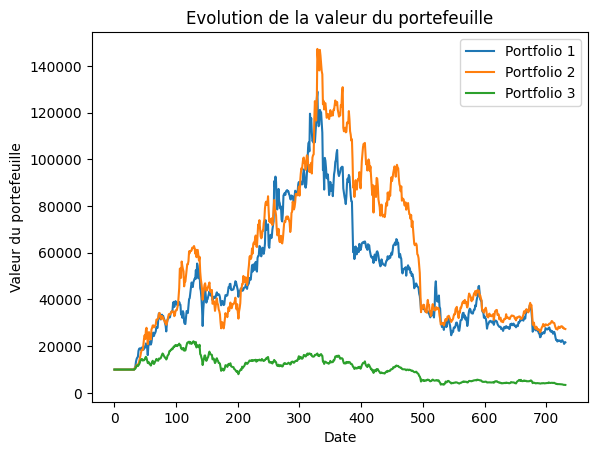

In [660]:
#on plot les 3 portefeuille
plt.plot(premier_portefeuille_decentralise, label="Portfolio 1")
plt.plot(deuxieme_portefeuille_decentralise, label="Portfolio 2")
plt.plot(troisieme_portefeuille_decentralise, label="Portfolio 3")
plt.title('Evolution de la valeur du portefeuille')
plt.xlabel('Date')
plt.ylabel('Valeur du portefeuille')
plt.legend()
plt.show()

**Expectations**

D'après la première partie de nos études, on s'attend à observer, tout comme dans cette première partie, une tendance haussière dans la première période suivie d'une tendance baissière pour la seconde partie.

**Results**:

Le portefeuille 1 et 2 se comportent de la même manière que ce qui a été étudié dans la première partie. Cependant, le troisième portefeuille sous-performe grandement en comparaison de tous les précédents portefeuilles.

### Daily returns

On va ensuite étudier les rendements journaliers des différents portefeuilles. Le graphique qui affiche ceux-ci au cours de la période d'étude des portefeuilles ne donne pas d'informations claires sur les différences de performance entre les portefeuilles. Chacun d'eux connaît des pics et des chutes importants. Pour obtenir davantage d'informations sur les rendements journaliers, nous allons alors procéder à une étude statistique.

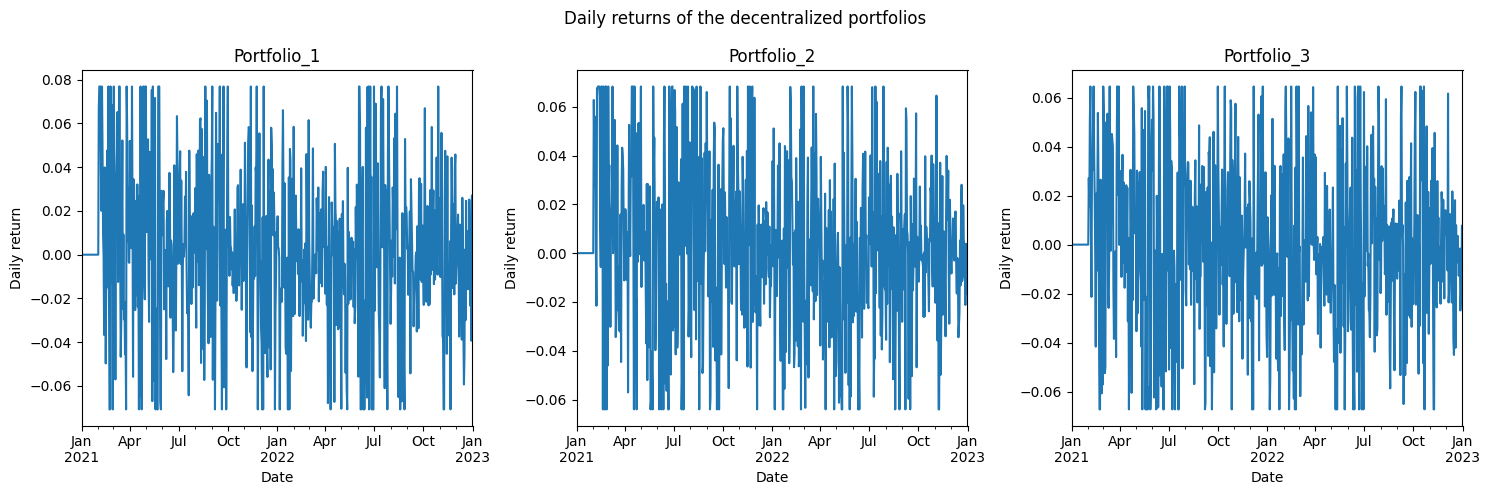

In [661]:
# Créer une liste de noms de portefeuilles décentralisés
portfolio_names_decentralized = ["Portfolio_1", "Portfolio_2", "Portfolio_3"]

# Créer une liste des portefeuilles décentralisés
decentralized_portfolios = [premier_portefeuille_decentralise, deuxieme_portefeuille_decentralise,
                            troisieme_portefeuille_decentralise]

# Créer un dictionnaire de données pour le DataFrame des portefeuilles décentralisés
portfolio_values_dict_decentralized = {name: portfolio for name, portfolio in zip(portfolio_names_decentralized, decentralized_portfolios)}

# Créer le DataFrame des portefeuilles décentralisés
portfolio_values_df_decentralized = pd.DataFrame(portfolio_values_dict_decentralized)
portfolio_values_df_decentralized = portfolio_values_df_decentralized.dropna()
portfolio_values_df_decentralized = portfolio_values_df_decentralized.iloc[1:]
portfolio_values_df_decentralized.index = decentralized_df.index

# Calculer les rendements quotidiens des portefeuilles décentralisés
portfolio_daily_returns_decentralized = portfolio_values_df_decentralized.pct_change()
# Appliquer la winsorisation sur chaque colonne du DataFrame
portfolio_daily_returns_decentralized = portfolio_daily_returns_decentralized.apply(winsorize_series, axis=0)

# Déterminer le nombre de sous-tracés nécessaires
num_subplots_decentralized = len(portfolio_daily_returns_decentralized.columns) // 3 + (len(portfolio_daily_returns_decentralized.columns) % 3 > 0)

# Créer les sous-tracés pour les portefeuilles décentralisés
fig_decentralized, axes_decentralized = plt.subplots(num_subplots_decentralized, 3, figsize=(15, 5 * num_subplots_decentralized))
fig_decentralized.suptitle('Daily returns of the decentralized portfolios')

# Afficher les graphiques des portefeuilles décentralisés
for i, ax in enumerate(axes_decentralized.flat):
    if i < len(portfolio_daily_returns_decentralized.columns):
        col_name_decentralized = portfolio_daily_returns_decentralized.columns[i]
        portfolio_daily_returns_decentralized[col_name_decentralized].plot(ax=ax, title=col_name_decentralized, xlabel='Date', ylabel='Daily return')
    else:
        ax.axis('off')  # Masquer les sous-tracés excédentaires s'il y en a

plt.tight_layout()
plt.show()


In [662]:
first_date = data_factors['timestamp'].min()
last_date = portfolio_daily_returns_decentralized.index.max()

all_dates = pd.date_range(start=first_date, end=last_date, freq='D')
rf_df = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'RF']], on='timestamp', how='left')
rf_df['RF'].fillna(method='ffill', inplace=True)
rf_df['RF'] = rf_df['RF'].str.replace(',', '.').astype(float)/100 

merged_decentralized = portfolio_daily_returns_decentralized.merge(rf_df, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_decentralized = merged_decentralized.loc[rebalancing_dates[0]:]
merged_decentralized = merged_decentralized.iloc[1:]
variance_merged_decentralized = merged_decentralized.std()

### Analyse statistique

In [663]:
#on fait les stats sur les daily return
indicators_decentralized = {}

for column in merged_decentralized.columns:
    returns = merged_decentralized[column]
    result = returns.describe()
    skewness = sm.stats.stattools.robust_skewness(returns)
    kurtosis = sm.stats.stattools.robust_kurtosis(returns)
    
    indicators_centralized[column] = {
        'Mean': result['mean'],
        'Stddev': result['std'],
        'Median': result['50%'],
        'Min': result['min'],
        'Max': result['max'],
        'Skewness': skewness[0],
        'Kurtosis': kurtosis[0]
    }

# Print the indicators for each returns series
for column, values in indicators_centralized.items():
    print(f"Indicators for {column}:")
    for indicator, value in values.items():
        print(f"{indicator}: {value}")
    print()



Indicators for Portfolio_1:
Mean: 0.0017423478114283342
Stddev: 0.03734635721494794
Median: 0.0010837845134297197
Min: -0.07070340685365549
Max: 0.07687667385866664
Skewness: 0.05849495755543591
Kurtosis: -0.34221760442147353

Indicators for Portfolio_2:
Mean: 0.0022300621953774947
Stddev: 0.03535071639901491
Median: 0.0018035613359446145
Min: -0.0640140899732423
Max: 0.06828427286147036
Skewness: 0.03561738234862736
Kurtosis: -0.6043773776606183

Indicators for Portfolio_3:
Mean: -0.00017539624037973025
Stddev: 0.03479392045714868
Median: -0.000901738207161995
Min: -0.0673003254980039
Max: 0.0646053096945303
Skewness: -0.0344616067658239
Kurtosis: -0.5896257546161356

Indicators for Portfolio_4:
Mean: 0.00219233507556838
Stddev: 0.03452177698502755
Median: 0.003082029828009647
Min: -0.07088482497259341
Max: 0.06584428645225117
Skewness: -0.16572183622660028
Kurtosis: -0.341750616004711

Indicators for Portfolio_5:
Mean: 0.0008033790784479958
Stddev: 0.03213432079552355
Median: 0.00152

**Expectations**:

On s'attend à obtenir de meilleures moyennes pour les portefeuilles 1 et 2, comme indiqué par le premier graphique, et certainement une moyenne négative pour le portefeuille 3. On prévoit également des valeurs d'écart-type élevées pour chacun des portefeuilles, étant donné la volatilité du marché des cryptomonnaies, ce qui se traduira par des écarts importants entre les valeurs maximales et minimales.


**Results**:


On observe effectivement que les portefeuilles 1 et 2 ont des rendements moyens élevés, tous les deux supérieurs à 0,17 %, notamment le portefeuille 2 avec un rendement de 0,22 %. Pour ce qui est du portefeuille 3, on observe effectivement une moyenne négative. Les trois portefeuilles présentent des écarts types élevés, comme vu précédemment.

In [664]:
portfolio_names = ['Portfolio_1', 'Portfolio_2', 'Portfolio_3']

for portfolio in portfolio_names:
    merged_decentralized[portfolio] -= merged_decentralized['RF']


### Ratio de Sharpe

In [665]:
#on calcul le ration de sharpe pour chaque portfolio de 1 a 3
sharpe_ratios_portfolios = (merged_decentralized.mean()) / variance_merged_decentralized.std()
print("Le ratio de sharpe des portefeuilles 1 à 3 :","\n",sharpe_ratios_portfolios[0:3])

Le ratio de sharpe des portefeuilles 1 à 3 : 
 Portfolio_1    0.095561
Portfolio_2    0.122771
Portfolio_3   -0.011431
dtype: float64


**Expectations**:

On s'attend à obtenir des ratios de Sharpe plutôt élevés pour les deux premiers portefeuilles, comme indiqué par les résultats précédents, mais surtout un Sharpe qui devrait être négatif pour le troisième car il rémunère moins que le taux sans risque.

**Results**:

Les résultats correspondent bien aux attentes avec le ratio de Sharpe le plus élevé pour le portefeuille 2. De plus, on obtient effectivement un ratio de Sharpe négatif pour le portefeuille 3 car le rendement est inférieur au taux sans risque.

In [666]:
decentralized_rf = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF']], on='timestamp', how='left')
decentralized_rf['Mkt-RF'].fillna(method='ffill', inplace=True)
decentralized_rf['Mkt-RF'] = decentralized_rf['Mkt-RF'].str.replace(',', '.').astype(float)/100

merged_decentralized_rf = merged_decentralized.merge(decentralized_rf, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_decentralized_rf = merged_decentralized_rf.loc[rebalancing_dates[0]:]
merged_decentralized_rf = merged_decentralized_rf.iloc[1:]

merged_decentralized_rf.head()

,Portfolio_1,Portfolio_2,Portfolio_3,RF,Mkt-RF
timestamp,,,,,
2021-02-03,0.076877,0.040924,0.015677,0.0,0.0015
2021-02-04,0.076877,0.027140,0.051302,0.0,0.0123
2021-02-05,0.076877,0.055916,0.064605,0.0,0.0058
2021-02-06,0.037875,0.000058,0.005885,0.0,0.0058
2021-02-07,0.020068,-0.021562,-0.021359,0.0,0.0058


### Regression pour obtenir l'alpha de Jensen et le Beta Market

In [667]:

# Perform the regression for each portfolio
for portfolio_index in range(1, 4):
    # Select the portfolio values and the Mkt-RF column
    X = merged_decentralized_rf['Mkt-RF']
    y = merged_decentralized_rf[f'Portfolio_{portfolio_index}']
    
    # Add a constant term to the independent variable
    X = sm.add_constant(X)
    
    # Fit the linear regression model
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Get the intercept (alpha) and slope (beta) coefficients
    alpha_decentralized = results.params[0]
    alpha_pvalue_decentralized = results.pvalues[0]
    beta_decentralized = results.params[1]
    beta_pvalue_decentralized = results.pvalues[1]
    
    # Print the alpha and beta coefficients
    print(f'Portfolio_{portfolio_index}:')
    print(f'Alpha (Jensen): {alpha_decentralized} p-value: {alpha_pvalue_decentralized}')
    print(f'Beta (Market): {beta_decentralized} p-value: {beta_pvalue_decentralized}')
    print()

Portfolio_1:
Alpha (Jensen): 0.0015197143352812363 p-value: 0.2701260281170988
Beta (Market): 0.6365127375309416 p-value: 2.3772694206027457e-09

Portfolio_2:
Alpha (Jensen): 0.0020022400622269586 p-value: 0.12105423233743064
Beta (Market): 0.7118745207571897 p-value: 1.3453211360147126e-12

Portfolio_3:
Alpha (Jensen): -0.00035886775517810496 p-value: 0.7771592558183984
Beta (Market): 0.731737289581404 p-value: 1.322779337284698e-13



**Expectations**:

On s'attend à ce que les bêtas des différents portefeuilles de cryptomonnaies soient positifs, car le marché des cryptos bénéficie du fait que les marchés financiers soient en bonne santé. Dans de tels cas, les investisseurs disposent de plus de moyens pour pouvoir investir dans le marché des cryptos. On s'attend à avoir des bêtas importants car le marché des cryptomonnaies, avec sa grande volatilité, aurait plutôt tendance à amplifier les variations du marché classique. Pour ce qui est des alphas, on s'attend à des valeurs positives pour les portefeuilles les plus performants et des valeurs négatives pour les portefeuilles les moins performants. En effet, ces alphas traduisent un surplus ou un déficit de rentabilité par rapport à ce qui peut être expliqué par le marché.


**Results**:

On obtient des valeurs proches de 0,65 pour les 2 premiers portefeuilles, variant entre 0,6 et 0,7. Les portefeuilles sont donc assez fortement corrélés positivement au marché. On ne peut pas conclure sur le fait qu'une valeur de bêta plus ou moins importante permettrait de meilleurs rendements. En effet, le portefeuille 1 a une valeur de bêta de 0,63 tandis que le portefeuille 2 a une valeur de bêta de 0,7. Or, ces 2 portefeuilles sont les plus performants. En revanche, le portefeuille 3 a également un bêta élevé de 0,7 sans être très performant.

L'alpha de Jensen du premier et du troisième portefeuille n'est pas significativement non nul, et on ne peut donc rien conclure à leur sujet. Pour celui du second, on obtient une p-valeur de 0,12, ce qui se rapproche d'une valeur significative, et on peut donc constater une valeur positive de l'alpha, ce qui est cohérent avec ses performances.



In [668]:

#on calcul le ration de sharpe pour chaque portfolio de 1 a 3
treynor_ratios_portfolios = (merged_decentralized_rf.mean()) / beta_decentralized
print("Le ratio de treynor des portefeuilles 1 à 3 sont :","\n",treynor_ratios_portfolios[0:3])

Le ratio de treynor des portefeuilles 1 à 3 sont : 
 Portfolio_1    0.002213
Portfolio_2    0.002889
Portfolio_3   -0.000334
dtype: float64


**Expectations**:

On s'attend, avec les résultats, à obtenir un ordre semblable pour les ratios de Treynor à ce qui a été obtenu avec les ratios de Sharpe : des ratios élevés pour les portefeuilles 1 et 2, et un ratio négatif pour le portefeuille 3.

**Results**:

Comme attendu, on obtient alors des résultats semblables à ceux des ratios de Sharpe. Les ratios pour les portefeuilles 1 et 2 sont les plus grands, et celui du portefeuille 3 est bien négatif car le rendement est inférieur au taux sans risque.

In [669]:
fm_decentralized = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF','HML','SMB']], on='timestamp', how='left')

fm_decentralized['Mkt-RF'].fillna(method='ffill', inplace=True)
fm_decentralized['Mkt-RF'] = fm_decentralized['Mkt-RF'].str.replace(',', '.').astype(float)/100
fm_decentralized['HML'].fillna(method='ffill', inplace=True)
fm_decentralized['HML'] = fm_decentralized['HML'].str.replace(',', '.').astype(float)/100
fm_decentralized['SMB'].fillna(method='ffill', inplace=True)
fm_decentralized['SMB'] = fm_decentralized['SMB'].str.replace(',', '.').astype(float)/100

fm_decentralized = merged_decentralized.merge(fm_decentralized, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
fm_decentralized = fm_decentralized.loc[rebalancing_dates[0]:]
fm_decentralized.head()

,Portfolio_1,Portfolio_2,Portfolio_3,RF,Mkt-RF,HML,SMB
timestamp,,,,,,,
2021-02-02,0.066886,0.062751,0.027216,0.0,0.0148,-0.0108,-0.0085
2021-02-03,0.076877,0.040924,0.015677,0.0,0.0015,0.0070,0.0043
2021-02-04,0.076877,0.027140,0.051302,0.0,0.0123,0.0037,0.0038
2021-02-05,0.076877,0.055916,0.064605,0.0,0.0058,-0.0047,0.0107
2021-02-06,0.037875,0.000058,0.005885,0.0,0.0058,-0.0047,0.0107


### Regression Fama & French

In [670]:
# Select the independent variables (Mkt-RF, SMB, HML)
X = fm_decentralized[['Mkt-RF', 'SMB', 'HML']]

# Select the dependent variables (portfolio returns)
y = fm_decentralized[['Portfolio_1', 'Portfolio_2', 'Portfolio_3']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Select each portfolio as a dependent variable and perform OLS regression
coefficients = {}
alphas = {}
alpha_pvalues = {}

for portfolio in y.columns:
    # Select the current portfolio as the dependent variable
    current_y = y[portfolio]

    # Perform OLS regression
    model = sm.OLS(current_y, X)
    results = model.fit()

    # Get the coefficients
    Bmarket = results.params['Mkt-RF']
    Bsmb = results.params['SMB']
    Bhml = results.params['HML']

    # Get the p-values for the coefficients
    beta_pvalues = results.pvalues[1:]

    # Get the alpha (intercept)
    alpha = results.params['const']
    
    # Get the p-value for the alpha coefficient
    alpha_pvalue = results.pvalues[0]

    # Store coefficients and alpha in dictionaries
    coefficients[portfolio] = {'Bmarket': Bmarket, 'Bsmb': Bsmb, 'Bhml': Bhml}
    alphas[portfolio] = alpha
    alpha_pvalues[portfolio] = alpha_pvalue

    # Print the coefficients and p-values for each portfolio
    print(f"\nPortfolio: {portfolio}")
    print(f"Bmarket={Bmarket} (p-value={beta_pvalues[0]}), Bsmb={Bsmb} (p-value={beta_pvalues[1]}), Bhml={Bhml} (p-value={beta_pvalues[2]})")
    print(f"Alpha={alpha} (p-value={alpha_pvalue})")



Portfolio: Portfolio_1
Bmarket=0.6541484424902498 (p-value=3.709553061391406e-08), Bsmb=0.13924172890540545 (p-value=0.4968989339351909), Bhml=0.1008261637248017 (p-value=0.46034845968456284)
Alpha=0.0015118129408071344 (p-value=0.27648037034473505)

Portfolio: Portfolio_2
Bmarket=0.7524592732695619 (p-value=1.7710137334888554e-11), Bsmb=-0.17165698292091908 (p-value=0.37123397066009955), Bhml=0.013288931103256777 (p-value=0.917235595062566)
Alpha=0.0020117591021029508 (p-value=0.12220784126989692)

Portfolio: Portfolio_3
Bmarket=0.7306157939205281 (p-value=2.8971087380066016e-11), Bsmb=-0.05458168019110016 (p-value=0.772081880928381), Bhml=-0.036446302461459266 (p-value=0.7716109878872304)
Alpha=-0.0003050404252128367 (p-value=0.8111906694732194)


**Expectations**:

On s'attend à ce que l’explication de la valeur des cryptomonnaies par les nouveaux facteurs ajoutés par le Modèle de Fama et French ne soit pas très bonne. En effet, les facteurs SMB et HML sont des facteurs très liés à la finance traditionnelle et qui ne semblent pas réellement avoir de lien avec la rentabilité des cryptomonnaies. On s’attend donc à avoir, pour ce modèle, des résultats proches de ceux du modèle avec l'alpha de Jensen, et donc des bêtas SMB et HML faibles ou nuls.

**Results**:

En réalité, on observe bien des résultats semblables à nos attentes. Les p-valeurs pour l’ensemble des bêtas SMB et HML sont importantes, ce qui signifie qu'ils ne sont pas significativement différents de 0. Ce modèle devient alors équivalent à celui étudié précédemment. On retrouve d’ailleurs des valeurs de bêta de marché et d'alpha de Fama et French qui sont similaires à celles évoquées lors de notre régression précédente. On peut ainsi douter de la pertinence du modèle de Fama et French pour étudier le cours de nos cryptomonnaies.